# **Prediction & Analysis of Data Based Job Roles in United States of America by Backward-Stepwise Regression Analysis**

# Table of Contents
* About
* Prepare Data
    * Import Libraries and Datasets
    * Clean Data
    * Prepare Variables for Regression Analysis
* Methodology
* Analysis Process (Codes)
* Key Preliminary Results
    * Job Titles vs Salaries (pie chart, distribution and errorbars)
    * Job Descriptions vs Salaries (bar chart and wordcloud)
    * Job Locations vs Salaries (bar chart with errorbars)
    * First Combined Regression Model Output
* Model Tuning
    * Tune the first combined model with Elastic Net
    * Introduce interaction terms
    * Final Model Output
    * Multicollinearity
* Final Regression Result in Visualisation

# About 

This dataset was created by "picklesueat" on Kaggle, and contains 12,000+ job listing for data science jobs (all assumed to be open positions at the time the dataset was published in July 2020), with features such as:

* Salary Estimate
* Location
* Company Rating
* Job Description
  and more.

## Objectives
* What kind of Data Science jobs get higher salaries? (Job Title, Job Description, EasyApply)
* What kind of companies pay more? (Rating, Company, Size, *Years established (now - Founded)*, Type of ownership, Industry & Sector, Revenue)
* Does job/headquarters location matter to salaries?

## Limitations and Assumptions

* The results only reflet the outcome at the time the dataset was published, which is pressumed to be July 2020. Seasonal variation is disregarded (not a time-series data).
* Somehow remote positions are not found in this dataset, so the impact of pandemic (more jobs becoming remote) on salary cannot be measured.
* The salary estimates come from Glassdoor, which may not reflect the actual salaries.
* The dataset is assumed to reflect the traits of the actual job market.
* The salaries are nominal, not adjusted by living costs or consumer price index.

# Data Preparation <a id="1"></a>

## Import Libraries and Dataset <a id="1-1"></a>

In [1]:
import numpy as np 
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from matplotlib.patches import Rectangle

# t-test
from scipy import stats

# regression - statsmodels
import statsmodels.regression.linear_model as sm
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# regression - sklearn
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# sqrt
from math import sqrt

# Word Cloud
from wordcloud import WordCloud

# function for inserting a row to a location
def Insert_row_(row_number, df, row_value): 
    # Slice the upper half of the dataframe 
    df1 = df[0:row_number]   
    # Store the result of lower half of the dataframe 
    df2 = df[row_number:]  
    # Inser the row in the upper half dataframe 
    df1.loc[row_number]=row_value 
    # Concat the two dataframes 
    df_result = pd.concat([df1, df2]) 
    # Reassign the index labels 
    df_result.index = [*range(df_result.shape[0])] 
    # Return the updated dataframe 
    return df_result

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
file = files.upload()  #upload file into google colab session
data_ds=pd.read_csv("DataScientist.csv")

Saving DataScientist.csv to DataScientist.csv


In [3]:
from google.colab import files
file = files.upload()  #upload file into google colab session
data_da=pd.read_csv("DataAnalyst.csv")

Saving DataAnalyst.csv to DataAnalyst.csv


In [4]:
from google.colab import files
file = files.upload()  #upload file into google colab session
data_de=pd.read_csv("DataEngineer.csv")

Saving DataEngineer.csv to DataEngineer.csv


In [5]:
from google.colab import files
file = files.upload()  #upload file into google colab session
data_ba=pd.read_csv("BusinessAnalyst.csv")

Saving BusinessAnalyst.csv to BusinessAnalyst.csv


In [6]:
data_ds = data_ds.drop(['Unnamed: 0','index'],axis=1)
data_da = data_da.drop(['Unnamed: 0'],axis=1)
data_ba = data_ba.drop(['Unnamed: 0','index'],axis=1).head(3692) # drop due to columns messed-up

data = pd.concat([data_ds,data_da,data_de,data_ba]).reset_index(drop=True)

## Clean Data <a id="1-2"></a>

In [7]:
# Missing value Check
def missing_values_table(df):
    # number 
    mis_val = df.isnull().sum()
    # % 
    mis_val_percent = 100 * mis_val / len(df)
    # Table formation 
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis=1) 
    # Column renaming
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0:'Missing Values',1:'% of Total Values'})
    # Column sorting
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values(
        '% of Total Values',ascending=False).round(1) #Review
    print("Your selected datset has "+str(df.shape[1])+" columns and "+str(len(df))+" observations.\n"
         "There are "+str(mis_val_table_ren_columns.shape[0])+" columns that have missing values.")
    # Missing values final table
    return mis_val_table_ren_columns

In [8]:
# String --> Float
data['Rating'] = data['Rating'].astype(float)
data['Easy Apply'] = data['Easy Apply'].replace('True',1)

# Replace with NaN
data=data.replace(-1,np.nan)
data=data.replace(-1.0,np.nan)
data=data.replace('-1',np.nan)

In [9]:
#Removing unnecessary data
data['Company Name'],_=data['Company Name'].str.split('\n', 1).str

# Split salary into two columns min salary and max salary.
data['Salary Estimate'],_=data['Salary Estimate'].str.split('(', 1).str

#Removing hourly salaries
data=data[(data['Salary Estimate'].str.contains(' Per Hour'))==False].reset_index(drop=True)

# Creating minimum and maximum salaries
data['Min_Salary'],data['Max_Salary']=data['Salary Estimate'].str.split('-').str
data['Min_Salary']=data['Min_Salary'].str.strip(' ').str.lstrip('$').str.rstrip('K').fillna(0).astype('int')
data['Max_Salary']=data['Max_Salary'].str.strip(' ').str.lstrip('$').str.rstrip('K').fillna(0).astype('int')

# Formula : Est_Salary = (Min_Salary+Max_Salary)/2
data['Est_Salary']=(data['Min_Salary']+data['Max_Salary'])/2

# Years of existence of company
data['Years_Founded'] = 2020 - data['Founded'].astype(float)

# Distribute 'City' and 'State'
data['City'],data['State'] = data['Location'].str.split(', ',1).str
data['HQCity'],data['HQState'] = data['Headquarters'].str.split(', ',1).str

# Fix duplication
data['State']=data['State'].replace('Arapahoe, CO','CO')
data['State']=data['State'].replace('Los Angeles, CA','CA')
data['HQState']=data['HQState'].replace('NY (US), NY','NY')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


In [10]:
# Number of jobs according to Company revenue
RevCount = data.groupby('Revenue')[['Job Title']].count().reset_index().rename(columns={'Job Title':'Hires'}).sort_values(
    'Hires', ascending=False).reset_index(drop=True)

# Clean the column 
RevCount["Revenue_USD"]=['Unknown','10+ billion','100-500 million','50-100 million','2-5 billion','10-25 million','1-2 billion','1-5 million','25-50 million','5-10 billion','<1 million','0.5-1 billion','5-10 million']

# Merge Revenue to column
RevCount2 = RevCount[['Revenue','Revenue_USD']]
RevCount = RevCount.merge(data, on='Revenue',how='left')
data=data.merge(RevCount2,on='Revenue',how='left')

In [11]:
missing_values_table(data)

Your selected datset has 24 columns and 12360 observations.
There are 15 columns that have missing values.


,Missing Values,% of Total Values
Easy Apply,11838,95.8
Competitors,8899,72.0
Founded,3148,25.5
Years_Founded,3148,25.5
Industry,1739,14.1
Sector,1736,14.0
Rating,1229,9.9
Headquarters,733,5.9
HQCity,733,5.9
HQState,733,5.9


## Prepare Variables for Regression Analysis <a id="1-3"></a> 

In [12]:
# Create new dataset
text_Analysis = data[['Job Title','Job Description','Est_Salary','Max_Salary','Min_Salary','City','State','Easy Apply','Revenue_USD','Rating','Size','Industry','Sector','Type of ownership','Years_Founded','Company Name','HQState']]

In [13]:
# Set sample size for t-test
ssize = 30

In [14]:
# Getting keywords from paragraphs
def get_keyword(x, note, VarSet):
   x_ = x.split(" ")
   keywords = []
   try:
      for word in x_:
         if word + note in np.asarray(VarSet):
            keywords.append(word + note)
   except:
      return -1

   return keywords

In [15]:
# Removing special char
text_Analysis['Revenue_USD'] = text_Analysis['Revenue_USD'].replace('Unknown','RevUnknown')
text_Analysis['Size'] = text_Analysis['Size'].replace('Unknown','SizeUnknown')
text_Analysis['Sector'] = text_Analysis['Sector'].replace('[^A-Za-z0-9]+', '_',regex=True).replace(['Government','Unknown'],['GovSec','SectorUnknown'])
text_Analysis['Industry'] = text_Analysis['Industry'].replace('[^A-Za-z0-9]+', '_',regex=True).replace('Unknown','IndUnknown')
text_Analysis['Type of ownership'] = text_Analysis['Type of ownership'].replace('[^A-Za-z0-9]+', '_',regex=True).replace('Unknown','OwnUnknown')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [16]:
# Rename column names
text_Analysis = text_Analysis.rename(columns={"Easy Apply":"Easy_Apply"})

### Get Keyword Variables from Job Titles

In [17]:
# remove special characters and unify some word use
text_Analysis['Job_title_2']= text_Analysis['Job Title'].str.upper().replace('[^A-Za-z0-9]+', ' ',regex=True)
text_Analysis['Job_title_2']= text_Analysis['Job_title_2'].str.upper().replace(
    ['Â','AND ','WITH ','SYSTEMS','OPERATIONS','ANALYTICS','SERVICES','ENGINEERS','NETWORKS','GAMES','MUSICS','INSIGHTS','SOLUTIONS','JR ','MARKETS','STANDARDS','FINANCE','PRODUCTS','DEVELOPERS','SR ',' 2'],
    ['','','','SYSTEM','OPERATION','ANALYTIC','SERVICE','ENGINEER','NETWORK','GAME','MUSIC','INSIGHT','SOLUTION','JUNIOR ','MARKET','STANDARD','FINANCIAL','PRODUCT','DEVELOPER','SENIOR ',' II'],regex=True)

# unify some word use
text_Analysis['Job_title_2']= text_Analysis['Job_title_2'].str.upper().replace(
    ['BUSINESS INTELLIGENCE','INFORMATION TECHNOLOGY','QUALITY ASSURANCE','USER EXPERIENCE','USER INTERFACE','DATA WAREHOUSE','DATA ANALYST','DATA BASE','DATA QUALITY','DATA GOVERNANCE','BUSINESS ANALYST','DATA MANAGEMENT','REPORTING ANALYST','BUSINESS DATA','SYSTEM ANALYST','DATA REPORTING','QUALITY ANALYST','DATA ENGINEER','BIG DATA','SOFTWARE ENGINEER','MACHINE LEARNING','FULL STACK','DATA SCIENTIST','DATA SCIENCE','DATA CENTER','ENTRY LEVEL','NEURAL NETWORK','SYSTEM ENGINEER',' ML '],
    ['BI','IT','QA','UX','UI','DATA_WAREHOUSE','DATA_ANALYST','DATABASE','DATA_QUALITY','DATA_GOVERNANCE','BUSINESS_ANALYST','DATA_MANAGEMENT','REPORTING_ANALYST','BUSINESS_DATA','SYSTEM_ANALYST','DATA_REPORTING','QUALITY_ANALYST','DATA_ENGINEER','BIG_DATA','SOFTWARE_ENGINEER','MACHINE_LEARNING','FULL_STACK','DATA_SCIENTIST','DATA_SCIENCE','DATA_CENTER','ENTRY_LEVEL','NEURAL_NETWORK','SYSTEM_ENGINEER',' MACHINE_LEARNING '],regex=True)

# unify some word use
text_Analysis['Job_title_2']= text_Analysis['Job_title_2'].str.upper().replace(
    ['DATA_ENGINEER JUNIOR','DATA_ENGINEER SENIOR','DATA  REPORTING_ANALYST','DATA ','BIG_DATA '],
    ['JUNIOR DATA_ENGINEER','SENIOR DATA_ENGINEER','DATA_REPORTING_ANALYST','DATA_','BIG_DATA_'],regex=True)

# get top keywords
s = text_Analysis['Job_title_2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
S = s[s['Count']>ssize]

# get keywords from each row
text_Analysis['KW'] = text_Analysis['Job_title_2'].apply(lambda x: get_keyword(x,'',S['KW']))

# create dummy columns by keywords
kwdummy = pd.get_dummies(text_Analysis['KW'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True).replace(np.nan,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


### Get Keyword Variables from Job Descriptions

In [18]:
# Create a list of big data buzzwords to see if those words in JD would influence the salary
buzzwords = ['COMPUTER_SCIENCE','MASTER','MBA','SQL','PYTHON','R','PHD','BUSINESS_ANALYTICS','SAS','PMP','SCRUM_MASTER','STATISTICS','MATHEMATICS','MACHINE_LEARNING','ARTIFICIAL_INTELLIGENCE','ECONOMICS','TABEAU','AWS','AZURE','POWER_BI','ALGORITHM','DEEP_LEARNING','NEURAL_NETWORK','NATURAL_LANGUAGE_PROCESSING','DECISION_TREE','REGRESSION','CLUSTER','ORACLE','EXCEL','TENSORFLOW','HADOOP','SPARK','NOSQL','SAP','ETL','API','PLSQL','MONGODB','POSTGRESQL','ELASTICSEARCH','REDIS','MYSQL','FIREBASE','SQLITE','CASSANDRA','DYNAMODB','OLTP','OLAP','DEVOPS','PLATFORM','NETWORK','APACHE','SECURITY','MARKDOWN']

In [19]:
# remove special characters and unify some word use
text_Analysis['Job_Desc2'] = text_Analysis['Job Description'].replace('[^A-Za-z0-9]+', ' ',regex=True)
text_Analysis['Job_Desc2'] = text_Analysis['Job_Desc2'].str.upper().replace(
    ['COMPUTER SCIENCE','ENGINEERING DEGREE',' MS ','BUSINESS ANALYTICS','SCRUM MASTER','MACHINE LEARNING',' ML ','POWER BI','ARTIFICIAL INTELLIGENCE',' AI ','ALGORITHMS','DEEP LEARNING','NEURAL NETWORK','NATURAL LANGUAGE PROCESSING','DECISION TREE','CLUSTERING','PL SQL'],
    ['COMPUTER_SCIENCE','ENGINEERING_DEGREE',' MASTER ','BUSINESS_ANALYTICS','SCRUM_MASTER','MACHINE_LEARNING',' MACHINE_LEARNING ','POWER_BI','ARTIFICIAL_INTELLIGENCE',' ARTIFICIAL_INTELLIGENCE ','ALGORITHM','DEEP_LEARNING','NEURAL_NETWORK','NATURAL_LANGUAGE_PROCESSING','DECISION_TREE','CLUSTER','PLSQL'],regex=True)

# Count the JD keywords.
S2 = text_Analysis['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
S2 = S2[S2['KW'].isin(buzzwords)].reset_index(drop=True)
S2['KWJD'] = S2['KW'] + '_JD'
S2 = S2[S2['Count']>ssize]

# get keywords from each row
text_Analysis['JDKW'] = text_Analysis['Job_Desc2'].apply(lambda x: get_keyword(x,'_JD',S2['KWJD']))

# create dummy columns by keywords
kwdummy = pd.get_dummies(text_Analysis['JDKW'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [20]:
# let's see if number of buzzwords contained or how wordy the JD is would have impact.
text_Analysis['JDKWlen']=text_Analysis['JDKW'].str.len()
text_Analysis['JDlen']=text_Analysis['Job Description'].str.len()

### Get Job Location Variables

In [21]:
## State ##
# Count the states frequency for t-test later
S3 = text_Analysis['State'].value_counts().reset_index().rename(
    columns={'index':'State','State':'Count'})
S3_Top = S3[S3['Count']>ssize]

# create dummy columns by State
kwdummy = pd.get_dummies(text_Analysis['State'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)

## City ##
text_Analysis['City']=text_Analysis['City'].str.replace(' ','_',regex=True)

# Count the city frequency for t-test later
S35 = text_Analysis['City'].value_counts().reset_index().rename(
    columns={'index':'City','City':'Count'})
S35_Top = S35[S35['Count']>ssize]

# create dummy columns by City
kwdummy = pd.get_dummies(text_Analysis[text_Analysis['City'].isin(np.asarray(S35_Top['City']))]['City'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)

## State where companies Headquarters locate at  ##
# Count the HQState frequency for t-test later
S31 = text_Analysis['HQState'].value_counts().reset_index().rename(
    columns={'index':'HQState','HQState':'Count'}).replace(0,'Unknown_State')
S31['HQState_HQ'] = [s + '_HQ' for s in S31['HQState']]
S31_Top = S31[S31['Count']>ssize]

# create dummy columns by HQ State
kwdummy = pd.get_dummies(S31_Top['HQState_HQ'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
S31_Top2 = S31_Top.merge(kwdummy,left_index=True,right_index=True,how='left').drop(['Count'],axis=1)
text_Analysis = text_Analysis.merge(S31_Top2,on='HQState',how='left').replace(np.nan,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


### Get More Variables: Revenue, Size, Sector and Type of Ownership

In [22]:
# create dummy columns by Revenue
kwdummy = pd.get_dummies(text_Analysis['Revenue_USD'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Revenue frequency for t-test later
S4 = text_Analysis['Revenue_USD'].value_counts().reset_index().rename(
    columns={'index':'Revenue_USD','Revenue_USD':'Count'})
S4_Top = S4[(S4['Count']>ssize) & (S4['Revenue_USD']!=0)]

# create dummy columns by Size
kwdummy = pd.get_dummies(text_Analysis['Size'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Size frequency for t-test later
S5 = text_Analysis['Size'].value_counts().reset_index().rename(
    columns={'index':'Size','Size':'Count'})
S5_Top = S5[(S5['Count']>ssize) & (S5['Size']!=0)]

# create dummy columns by Sector
kwdummy = pd.get_dummies(text_Analysis['Sector'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Sector frequency for t-test later
S6 = text_Analysis['Sector'].value_counts().reset_index().rename(
    columns={'index':'Sector','Sector':'Count'})
S6 = S6[S6['Sector']!=0]
S6_Top = S6[(S6['Count']>ssize)]

# create dummy columns by Type of Ownership
kwdummy = pd.get_dummies(text_Analysis['Type of ownership'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Type of ownership frequency for t-test later
S8 = text_Analysis['Type of ownership'].value_counts().reset_index().rename(
    columns={'index':'Type_of_ownership','Type of ownership':'Count'})
S8_Top = S8[(S8['Count']>ssize) & (S8['Type_of_ownership']!=0)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and wi

In [145]:
# Packages
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

In [146]:
data1


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,Easy Apply,Min_Salary,Max_Salary,Est_Salary,Years_Founded,City,State,HQCity,HQState,Revenue_USD
15,Data Scientist,$111K-$181K,Data Scientist\nAffinity Solutions / Marketing...,3.0000,Affinity Solutions,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,1.0000,111,181,146.0000,22.0000,New York,NY,New York,NY,Unknown
34,Data Science Analyst,$120K-$140K,Data Science Analyst\n\nJob Details\nLevel\nEx...,3.7000,GNY Insurance Companies,"New York, NY","New York, NY",201 to 500 employees,1914,Company - Private,...,1.0000,120,140,130.0000,106.0000,New York,NY,New York,NY,100-500 million
66,People Analytics Data Scientist,$119K-$147K,What you’ll do day-to-day\n\n\nThe data scient...,4.4000,D. E. Shaw & Co.,"New York, NY","New York, NY",1001 to 5000 employees,1988,Company - Private,...,1.0000,119,147,133.0000,32.0000,New York,NY,New York,NY,Unknown
68,Credit Analytics Manager,$119K-$147K,"About Liberty Lending, LLC\n\nLiberty Lending,...",4.0000,Liberty Lending,"New York, NY","New York, NY",51 to 200 employees,2015,Company - Private,...,1.0000,119,147,133.0000,5.0000,New York,NY,New York,NY,Unknown
74,Data Engineer (Python),$74K-$124K,What we're looking for\n\nWe are looking for a...,4.4000,Conductor,"New York, NY","New York, NY",201 to 500 employees,2010,Company - Private,...,1.0000,74,124,99.0000,10.0000,New York,NY,New York,NY,1-2 billion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11543,Business Analyst - Core Development,$47K-$88K,RamQuest is a Texas-based corporation that has...,3.3000,RamQuest,"Plano, TX","Plano, TX",51 to 200 employees,1991,Company - Public,...,1.0000,47,88,67.5000,29.0000,Plano,TX,Plano,TX,Unknown
11581,Business Analyst/Data Consultant,$41K-$80K,Job Description\n\n\nJob #: 1071315\n\nDevelop...,3.8000,Apex Systems,"Irving, TX","Glen Allen, VA",1001 to 5000 employees,1995,Subsidiary or Business Segment,...,1.0000,41,80,60.5000,25.0000,Irving,TX,Glen Allen,VA,2-5 billion
12081,Business Analyst,$43K-$78K,Job Description\n\n\nJob #: 1071859\n\nJob Typ...,3.8000,Apex Systems,"Austin, TX","Glen Allen, VA",1001 to 5000 employees,1995,Subsidiary or Business Segment,...,1.0000,43,78,60.5000,25.0000,Austin,TX,Glen Allen,VA,2-5 billion
12092,Digital Marketing Analyst,$48K-$87K,"As Digital Marketing Analyst, you will oversee...",3.4000,All Web Leads,"Austin, TX","Austin, TX",201 to 500 employees,2005,Company - Private,...,1.0000,48,87,67.5000,15.0000,Austin,TX,Austin,TX,100-500 million


In [147]:
data1=data.dropna()
data1=data.dropna(axis=0)

In [148]:
#import data
jobs = data1
feature_names_jobs = ['Rating', 'City', 'Max_Salary', 'Type of ownership'] #x variable names
X_jobs = jobs[feature_names_jobs] #setting the col names
y_jobs = jobs['Job Title'] #setting the col names
target_names_jobs = ['Data Scientist', 'Data Analyst', 'Data Engineer', 'Business Analyst'] #potential classes
jobs.head(10)


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,Easy Apply,Min_Salary,Max_Salary,Est_Salary,Years_Founded,City,State,HQCity,HQState,Revenue_USD
15,Data Scientist,$111K-$181K,Data Scientist\nAffinity Solutions / Marketing...,3.0000,Affinity Solutions,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,1.0000,111,181,146.0000,22.0000,New York,NY,New York,NY,Unknown
34,Data Science Analyst,$120K-$140K,Data Science Analyst\n\nJob Details\nLevel\nEx...,3.7000,GNY Insurance Companies,"New York, NY","New York, NY",201 to 500 employees,1914,Company - Private,...,1.0000,120,140,130.0000,106.0000,New York,NY,New York,NY,100-500 million
66,People Analytics Data Scientist,$119K-$147K,What you’ll do day-to-day\n\n\nThe data scient...,4.4000,D. E. Shaw & Co.,"New York, NY","New York, NY",1001 to 5000 employees,1988,Company - Private,...,1.0000,119,147,133.0000,32.0000,New York,NY,New York,NY,Unknown
68,Credit Analytics Manager,$119K-$147K,"About Liberty Lending, LLC\n\nLiberty Lending,...",4.0000,Liberty Lending,"New York, NY","New York, NY",51 to 200 employees,2015,Company - Private,...,1.0000,119,147,133.0000,5.0000,New York,NY,New York,NY,Unknown
74,Data Engineer (Python),$74K-$124K,What we're looking for\n\nWe are looking for a...,4.4000,Conductor,"New York, NY","New York, NY",201 to 500 employees,2010,Company - Private,...,1.0000,74,124,99.0000,10.0000,New York,NY,New York,NY,1-2 billion
127,Quantitative Analyst Intern,$102K-$121K,What you’ll do day-to-day\n\n\nFor quantitativ...,4.4000,D. E. Shaw & Co.,"New York, NY","New York, NY",1001 to 5000 employees,1988,Company - Private,...,1.0000,102,121,111.5000,32.0000,New York,NY,New York,NY,Unknown
156,Data Scientist II,$129K-$210K,About Us\n\nMediaMath is a leading global inde...,3.6000,MediaMath,"New York, NY","New York, NY",501 to 1000 employees,2007,Company - Private,...,1.0000,129,210,169.5000,13.0000,New York,NY,New York,NY,100-500 million
164,Data Analyst,$156K-$254K,Undertone stands alone among AdTech and ad net...,3.8000,Undertone,"New York, NY","New York, NY",201 to 500 employees,2001,Subsidiary or Business Segment,...,1.0000,156,254,205.0000,19.0000,New York,NY,New York,NY,Unknown
201,Data Analyst,$119K-$147K,MediaMath is a leading global independent adve...,3.6000,MediaMath,"New York, NY","New York, NY",501 to 1000 employees,2007,Company - Private,...,1.0000,119,147,133.0000,13.0000,New York,NY,New York,NY,100-500 million
221,Data Engineer,$119K-$147K,Data Engineer\n\nJob Details\nLevel\nExperienc...,3.7000,GNY Insurance Companies,"New York, NY","New York, NY",201 to 500 employees,1914,Company - Private,...,1.0000,119,147,133.0000,106.0000,New York,NY,New York,NY,100-500 million


In [161]:
import math


def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

In [182]:
# setting up the 2 dimensional array of height and width predictors. other x vars discarded
X_jobs_2d = jobs[['Max_Salary', 'Rating']]
y_jobs_2d = jobs['Job Title'] #labels

In [184]:
#75 / 25 train test split
X_train, X_test, y_train, y_test = train_test_split(X_jobs_2d, y_jobs_2d, random_state=0)

In [200]:
print(X_train)

       Max_Salary  Rating
6590          158  3.2000
3904           66  3.8000
6144          150  3.7000
10699         102  3.8000
495           125  3.8000
...           ...     ...
6627          210  3.2000
4677           92  3.2000
7554          181  3.6000
2912          175  3.0000
10801          81  3.8000

[140 rows x 2 columns]


In [185]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

In [201]:
print(X_train_scaled)

[[0.57297297 0.29166667]
 [0.07567568 0.54166667]
 [0.52972973 0.5       ]
 [0.27027027 0.54166667]
 [0.39459459 0.54166667]
 [0.19459459 0.54166667]
 [0.35675676 0.33333333]
 [0.93513514 0.54166667]
 [0.11351351 0.29166667]
 [0.8972973  0.29166667]
 [0.73513514 0.79166667]
 [0.2972973  0.54166667]
 [0.5027027  0.08333333]
 [0.47567568 0.54166667]
 [0.28108108 0.20833333]
 [0.71351351 0.58333333]
 [0.47567568 0.54166667]
 [0.55135135 0.20833333]
 [0.42162162 0.        ]
 [0.6972973  0.54166667]
 [0.50810811 0.41666667]
 [0.61621622 0.79166667]
 [0.30810811 0.29166667]
 [0.31891892 1.        ]
 [0.2972973  0.33333333]
 [0.66486486 0.83333333]
 [0.15135135 0.54166667]
 [0.62162162 0.375     ]
 [0.19459459 0.33333333]
 [0.51351351 0.79166667]
 [0.07567568 0.5       ]
 [0.19459459 0.33333333]
 [0.4        0.75      ]
 [0.52432432 0.66666667]
 [0.47027027 0.41666667]
 [0.32972973 0.58333333]
 [0.22162162 0.25      ]
 [0.21621622 0.25      ]
 [0.27027027 0.54166667]
 [0.27027027 0.375     ]


In [186]:
X_train = X_train.fillna(X_train.mean())

In [187]:
knn = KNeighborsClassifier(n_neighbors = 5) #setting up the KNN model to use 5NN
knn.fit(X_train_scaled, y_train) #fitting the KNN

KNeighborsClassifier()

In [188]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_scaled, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_scaled, y_test)))

Accuracy of K-NN classifier on training set: 0.26
Accuracy of K-NN classifier on test set: 0.15


In [199]:
example_job = [[100, 3]]
print(example_job)

[[100, 3]]


In [204]:
example_job = [[int(100), int(3)]]
example_job_scaled = scaler.transform(example_job)
print(example_job)
print(example_job_scaled)
#Making an prediction based on x values
print('Predicted job type for ', example_job, ' is ', 
          target_names_jobs[knn.predict(example_job_scaled)[0]-1])

[[100, 3]]
[[0.25945946 0.20833333]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


TypeError: ignored

In [208]:
type(example_job)
type(example_job[1])

IndexError: ignored

In [ ]:
typ

In [202]:
print(scaler.transform(example_job))

[[0.25945946 0.20833333]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
from adspy_shared_utilities import plot_two_class_knn
X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2,
 random_state=0)
plot_two_class_knn(X_train, y_train, 1, ‘uniform’, X_test, y_test)
plot_two_class_knn(X_train, y_train, 5, ‘uniform’, X_test, y_test)
plot_two_class_knn(X_train, y_train, 11, ‘uniform’, X_test, y_test)

# Methodology: Backward-stepwise Regression 

This Backward-stepwise Regression is designed for the scenario that**, within a limited time, needs to run regression analysis with the dataset containing lots of categorical data as independent variables.** 

Key steps:

1. Categorical variable groups: for example, city, state, job title keywords...etc.
2. Create dummy variables for each value whose presence in the dataset is at least >29.
3. After splitting training/validating/testing datasets, perform T-tests and remove variables by p-value threshold 0.1.
4. Perform backward-stepwise regression (p-value threshold 0.05) on variables that passed the T-tests in each variable group.
5. Include all the variables having passed the preliminary regression models and re-run backward-stepwise regression.
6. Plot the validation errors by Elastic Net alpha's to see how to tune the model (remove or add variables). At the same time, observe multicollinearity, consider interaction terms...etc.
7. Compare the models and make the final decision.

In [23]:
def splittingSets(df, y):
    X = df.drop([y],axis=1)
    y = df[y]

    X_int, X_test, y_int, y_test = train_test_split(X,y,shuffle=False,test_size=0.2,random_state=15)
    X_train, X_val, y_train, y_val = train_test_split(X_int,y_int,shuffle=False,test_size=0.25,random_state=15)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [24]:
def ttest(setX):
    text_columns = list(X_train.columns)
    ttests=[]
    for word in text_columns:
        if word in set(setX):
            ttest = stats.ttest_ind(y_train[X_train[word]==1],
                                    y_train[X_train[word]==0])
            ttests.append([word,ttest])
    ttests = pd.DataFrame(ttests,columns=['Var','R'])
    ttests['R']=ttests['R'].astype(str).replace(['Ttest_indResult\(statistic=','pvalue=','\)'],['','',''],regex=True)
    ttests['Statistic'],ttests['P-value']=ttests['R'].str.split(', ',1).str
    ttests=ttests.drop(['R'],axis=1).sort_values('P-value',ascending=True)
    return ttests

In [25]:
def VarFromTtests(ttests_var,ttest_p):
    ttest_var_pass = ttests_var[ttests_var['P-value'].astype(float)<ttest_p].reset_index(drop=True)
    ttest_pass = list(ttest_var_pass['Var'])
    
    #build table for variables from ttest results
    ttests_var_pass_KW = list(ttest_pass)
    ttests_var_pass_KW.insert(0,'Const')
    ttests_var_pass_KW = pd.DataFrame(ttests_var_pass_KW,columns=['Var'])

    #list of variables to be put in the model
    model_var = list(ttest_pass)
    model_var.insert(0,'Const')

    #list of variables removed
    var_remove = []
    
    return ttests_var_pass_KW, model_var, var_remove, ttest_pass

In [26]:
def buildmodel(X_opt, var_name):
    Mod = sm.OLS(endog = y_train, exog = X_opt).fit() 
    results_summary = Mod.summary(xname=var_name)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(
        sm.OLS(endog = y_train, exog = X_opt).exog, i) for i in range(
        1, sm.OLS(endog = y_train, exog = X_opt).exog.shape[1])]
    vif = Insert_row_(0, vif, np.nan)
    return results_summary, vif, Mod

In [27]:
def resulttable(results_summary):
    results_as_html = results_summary.tables[1].as_html()
    results_as_html = pd.read_html(results_as_html, header=0, index_col=0)[0]
    result_data = pd.DataFrame(results_as_html)
    return result_data

In [28]:
def resulttables(results_summary, vif):
    results_as_html0 = results_summary.tables[0].as_html()
    results_as_html1 = results_summary.tables[1].as_html()
    results_as_html2 = results_summary.tables[2].as_html()
    results_as_html0 = pd.read_html(results_as_html0, header=0, index_col=0)[0]
    results_as_html1 = pd.read_html(results_as_html1, header=0, index_col=0)[0]
    results_as_html2 = pd.read_html(results_as_html2, header=0, index_col=0)[0]
    result_data0 = pd.DataFrame(results_as_html0)
    result_data1 = pd.DataFrame(results_as_html1).reset_index()
    result_data1 = result_data1.merge(vif, right_index=True, left_index=True)
    result_data2 = pd.DataFrame(results_as_html2)
    return result_data0, result_data1, result_data2

In [29]:
# Create Backward functions
def backwardeliminate(model_var, var_remove, ttest_pass_KW, ttest_pass):
    for ele in model_var:
        if ele in var_remove:
            model_var.remove(ele)
    ttest_pass_KW = ttest_pass_KW[ttest_pass_KW['Var'].isin(model_var)]
    var_idx = ttest_pass_KW['Var'].index.tolist()
    X_train0 = X_train[ttest_pass]
    X_train1 = np.append(arr = np.ones((len(X_train0), 1)).astype(int),
                         values = X_train0, axis = 1)
    X_opt = X_train1[:,var_idx]
    var_name = list(ttest_pass_KW['Var'])
    return X_opt, var_name

In [30]:
def scalibility(FINAL_MODEL_NAME, Mod_Final_1, Mod_Final_2):
    global modelperform
    X_train0 = X_train[Mod_Final_2[Mod_Final_2['index']!='Const']['index']]
    X_train1 = np.append(arr = np.ones((len(X_train0), 1)).astype(int),values = X_train0, axis = 1)

    X_val0 = X_val[Mod_Final_2[Mod_Final_2['index']!='Const']['index']]
    X_val1 = np.append(arr = np.ones((len(X_val0), 1)).astype(int),values = X_val0, axis = 1)

    X_test0 = X_test[Mod_Final_2[Mod_Final_2['index']!='Const']['index']]
    X_test1 = np.append(arr = np.ones((len(X_test0), 1)).astype(int),values = X_test0, axis = 1)
        
    new_row = {'Model': FINAL_MODEL_NAME,'Adj. R-squared': Mod_Final_1.iloc[0][2],
               'AIC': Mod_Final_1.iloc[4][2],'BIC': Mod_Final_1.iloc[5][2],
               'R2':r2_score(np.asarray(y_train),sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_train1)),
               'RMSE':sqrt(mean_squared_error(np.asarray(y_train),
                                       sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_train1))),
               'R2_val':r2_score(np.asarray(y_val),sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_val1)),
               'RMSE_val':sqrt(mean_squared_error(np.asarray(y_val),
                                       sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_val1))),
               'R2_test':r2_score(np.asarray(y_test),sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_test1)),
               'RMSE_test':sqrt(mean_squared_error(np.asarray(y_test),
                                       sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_test1)))}

    pd.options.display.float_format = '{:.4f}'.format
    modelperform = modelperform.append(new_row, ignore_index=True)
    
    return modelperform, X_train1, X_val1, X_test1

In [31]:
def multicol(Coef_Final):
    multivlsit = Coef_Final.index.tolist()
    multivlsit.remove('Const')
    corr_df = X_train[multivlsit].corr(method='pearson')
    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = True
    
    sns.set(style='white')
    fig = plt.figure(figsize=(13, 13))
    sns.heatmap(corr_df, cmap='RdYlGn_r', vmax = 1.0, vmin = -1.0, mask = mask, linewidths = 2.5)
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 90)
    plt.show()

In [32]:
def addTopInteractions():
    global X_train, X_val, X_test, Interactions_Top
    X_train0 = X_train[Mod_Final_2[Mod_Final_2['index']!='Const']['index']]
    baseline = np.mean(cross_val_score(linear_model.LinearRegression(), X_train0, y_train, scoring='r2', cv=3, n_jobs=1))
    interactions = list()
    for feature_A in X_train0.columns:
        for feature_B in X_train0.columns:
            if feature_A > feature_B:
                X_train0['interaction'] = X_train0[feature_A] * X_train0[feature_B]
                score = np.mean(cross_val_score(linear_model.LinearRegression(), X_train0, y_train, scoring='r2',
                                       cv=3, n_jobs=1))
                if score > baseline:
                    interactions.append((feature_A, feature_B, round(score,3)))

    Interactions = pd.DataFrame(interactions)
    Interactions = Interactions.sort_values(2,ascending=False).reset_index(drop=True)
    Interactions_Top = Interactions.iloc[0:9,:]
    Interactions_Top['inter'] = Interactions_Top[0]+'*'+Interactions_Top[1]

    for i in Interactions_Top.index:
        X_train[Interactions_Top.iloc[i]['inter']] = X_train[
            Interactions_Top.iloc[i][0]]*X_train[Interactions_Top.iloc[i][1]]
        X_val[Interactions_Top.iloc[i]['inter']] = X_val[
            Interactions_Top.iloc[i][0]]*X_val[Interactions_Top.iloc[i][1]]
        X_test[Interactions_Top.iloc[i]['inter']] = X_test[
            Interactions_Top.iloc[i][0]]*X_test[Interactions_Top.iloc[i][1]]
        if sum(X_train[Interactions_Top.iloc[i]['inter']]) < ssize:
            X_train = X_train.iloc[:,0:-1]

    X_val = X_val[X_train.columns]
    X_test = X_test[X_test.columns]
    return X_train, X_val, X_test, Interactions_Top

In [33]:
def ElasticNetPlot(alpha_max, alpha_step, L1_wt_value):
    ols_rmse_val=sqrt(mean_squared_error(np.asarray(y_val),
                                       sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_val1)))

    EN_rmse_val=[]
    for alpha in np.arange(0, alpha_max, alpha_step):
        # L1_wt: (0)Ridge - (1)Lasso
        EN_rmse_val.append(sqrt(mean_squared_error(np.asarray(y_val),sm.OLS(
            endog = y_train, exog = X_train1).fit_regularized(method='elastic_net', alpha=alpha, L1_wt = L1_wt_value).predict(X_val1))))

    # plot rmse
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.plot(np.arange(0, alpha_max, alpha_step), EN_rmse_val, 'ro')
    plt.axhline(y=ols_rmse_val, color='g', linestyle='--')
    plt.title("Elatic Net Validation RMSE", fontsize=16)
    plt.xlabel("Model Simplicity$\longrightarrow$")
    plt.ylabel("RMSE")
    plt.show()

In [34]:
def coefficientbars(alpha_value, L1_wt_value, Mod_Final_2):
    mod_min_val_err = sm.OLS(endog = y_train, exog = X_train1).fit_regularized(method='elastic_net', alpha=alpha_value, L1_wt = L1_wt_value)
    regularized_regression_parameters = mod_min_val_err.params.reset_index()

    sns.set(style='white')
    reg_fit = Mod_Final_2['index'].reset_index()
    reg_fit = reg_fit.merge(regularized_regression_parameters, right_index=True, left_index=True).drop(
        ['level_0','index_y'],axis=1).rename(columns={'index_x':'Var',0:'Coefficient'}).sort_values(
        'Coefficient',ascending=False).reset_index(drop=True)
    reg_fit = reg_fit[reg_fit['Var']!='Const']

    fig = plt.figure(figsize=(13, 5))
    sns.barplot(x='Var',y='Coefficient',data=reg_fit).set(xlabel="",ylabel="Salary Performance \n Against Average")

    plt.xticks(rotation=45,horizontalalignment='right')
    plt.show()

# Analysis Process (Codes) - BACKWARD STEPWISE REGRESSION MODEL <a id="ap"></a>

In [35]:
ssize = 30 # set minimum sample size for each variable
ttest_p = 0.1 # set p-value threshold for t-test
regr_p = 0.05 # set p-value threshold for eliminating variables from regression

X_train, X_val, X_test, y_train, y_val, y_test = splittingSets(text_Analysis, 'Est_Salary')
finalVar=['Years_Founded','Rating','JDKWlen','JDlen','Easy_Apply']

# Job Titles
ttests_title = ttest(s[(s['Count']>=ssize)&(s['KW']!=0)]['KW'])
ttests_title_pass_KW, model_title, title_remove, ttests_title_pass = VarFromTtests(ttests_title, ttest_p)
X_opt_title, title_name = backwardeliminate(model_title, title_remove, ttests_title_pass_KW, ttests_title_pass)
Mod_title, VIF_title, mod_title = buildmodel(X_opt_title, title_name)
Coef_title = resulttable(Mod_title)

i = max(Coef_title['P>|t|'])
while i > regr_p:
    if Coef_title[Coef_title['P>|t|']==i].index.values[0] != 'Const':
        title_remove.append(Coef_title[Coef_title['P>|t|']==i].index.values[0])
        X_opt_title, title_name = backwardeliminate(model_title, title_remove, ttests_title_pass_KW, ttests_title_pass)
        Mod_title, VIF_title, mod_title = buildmodel(X_opt_title, title_name)
        Coef_title = resulttable(Mod_title)
        i = max(Coef_title['P>|t|'])
    else:
        continue

finalVar += Coef_title['coef'].index.tolist()
Mod_title_1,Mod_title_2,Mod_title_3 = resulttables(Mod_title, VIF_title)

# Job Description
ttests_JD = ttest(S2[(S2['Count']>=ssize)&(S2['KW']!=0)]['KWJD']) 
ttests_JD_pass_KW, model_JD, JD_remove, ttests_JD_pass = VarFromTtests(ttests_JD, ttest_p)
X_opt_JD, JD_name = backwardeliminate(model_JD, JD_remove, ttests_JD_pass_KW, ttests_JD_pass)
Mod_JD, VIF_JD, mod_JD = buildmodel(X_opt_JD, JD_name)
Coef_JD = resulttable(Mod_JD)

i = max(Coef_JD['P>|t|'])
while i > regr_p:
    if Coef_JD[Coef_JD['P>|t|']==i].index.values[0] != 'Const':
        JD_remove.append(Coef_JD[Coef_JD['P>|t|']==i].index.values[0])
        X_opt_JD, JD_name = backwardeliminate(model_JD, JD_remove, ttests_JD_pass_KW, ttests_JD_pass)
        Mod_JD, VIF_JD, mod_JD = buildmodel(X_opt_JD, JD_name)
        Coef_JD = resulttable(Mod_JD)
        i = max(Coef_JD['P>|t|'])
    else:
        continue

finalVar += Coef_JD['coef'].index.tolist()
Mod_JD_1,Mod_JD_2,Mod_JD_3 = resulttables(Mod_JD, VIF_JD)

# Location State
ttests_State = ttest(S3[(S3['Count']>=ssize)&(S3['State']!=0)]['State'])
ttests_State_pass_KW, model_State, State_remove, ttests_State_pass = VarFromTtests(ttests_State, ttest_p)
X_opt_State, State_name = backwardeliminate(model_State, State_remove, ttests_State_pass_KW, ttests_State_pass)
Mod_State, VIF_State, mod_State = buildmodel(X_opt_State, State_name)
Coef_State = resulttable(Mod_State)

i = max(Coef_State['P>|t|'])
while i > regr_p:
    if Coef_State[Coef_State['P>|t|']==i].index.values[0] != 'Const':
        State_remove.append(Coef_State[Coef_State['P>|t|']==i].index.values[0])
        X_opt_State, State_name = backwardeliminate(model_State, State_remove, ttests_State_pass_KW, ttests_State_pass)
        Mod_State, VIF_State, mod_State = buildmodel(X_opt_State, State_name)
        Coef_State = resulttable(Mod_State)
        i = max(Coef_State['P>|t|'])
    else:
        continue

finalVar += Coef_State['coef'].index.tolist()
Mod_State_1,Mod_State_2,Mod_State_3 = resulttables(Mod_State, VIF_State)

# Location City
ttests_city = ttest(S35[(S35['Count']>=ssize)&(S35['City']!=0)]['City'])
ttests_city_pass_KW, model_city, city_remove, ttests_city_pass = VarFromTtests(ttests_city, ttest_p)
X_opt_city, city_name = backwardeliminate(model_city, city_remove, ttests_city_pass_KW, ttests_city_pass)
Mod_city, VIF_city, mod_city = buildmodel(X_opt_city, city_name)
Coef_city = resulttable(Mod_city)

i = max(Coef_city['P>|t|'])
while i > regr_p:
    if Coef_city[Coef_city['P>|t|']==i].index.values[0] != 'Const':
        city_remove.append(Coef_city[Coef_city['P>|t|']==i].index.values[0])
        X_opt_city, city_name = backwardeliminate(model_city, city_remove, ttests_city_pass_KW, ttests_city_pass)
        Mod_city, VIF_city, mod_city = buildmodel(X_opt_city, city_name)
        Coef_city = resulttable(Mod_city)
        i = max(Coef_city['P>|t|'])
    else:
        continue

finalVar += Coef_city['coef'].index.tolist()
Mod_city_1,Mod_city_2,Mod_city_3 = resulttables(Mod_city, VIF_city)

# Company HeadQuarters State
ttests_HQState = ttest(S31[(S31['Count']>=ssize)&(S31['HQState_HQ']!=0)]['HQState_HQ'])
ttests_HQState_pass_KW, model_HQState, HQState_remove, ttests_HQState_pass = VarFromTtests(ttests_HQState, ttest_p)
X_opt_HQState, HQState_name = backwardeliminate(model_HQState, HQState_remove, ttests_HQState_pass_KW, ttests_HQState_pass)
Mod_HQState, VIF_HQState, mod_HQState = buildmodel(X_opt_HQState, HQState_name)
Coef_HQState = resulttable(Mod_HQState)

i = max(Coef_HQState['P>|t|'])
while i > regr_p:
    if Coef_HQState[Coef_HQState['P>|t|']==i].index.values[0] != 'Const':
        HQState_remove.append(Coef_HQState[Coef_HQState['P>|t|']==i].index.values[0])
        X_opt_HQState, HQState_name = backwardeliminate(model_HQState, HQState_remove, ttests_HQState_pass_KW, ttests_HQState_pass)
        Mod_HQState, VIF_HQState, mod_HQState = buildmodel(X_opt_HQState, HQState_name)
        Coef_HQState = resulttable(Mod_HQState)
        i = max(Coef_HQState['P>|t|'])
    else:
        continue

finalVar += Coef_HQState['coef'].index.tolist()
Mod_HQState_1,Mod_HQState_2,Mod_HQState_3 = resulttables(Mod_HQState, VIF_HQState)

# Company Revenue
ttests_Revenue = ttest(S4[(S4['Count']>=ssize)&(S4['Revenue_USD']!=0)]['Revenue_USD'])
ttests_Revenue_pass_KW, model_Revenue, Revenue_remove, ttests_Revenue_pass = VarFromTtests(ttests_Revenue, ttest_p)
X_opt_Revenue, Revenue_name = backwardeliminate(model_Revenue, Revenue_remove, ttests_Revenue_pass_KW, ttests_Revenue_pass)
Mod_Revenue, VIF_Revenue, mod_Revenue = buildmodel(X_opt_Revenue, Revenue_name)
Coef_Revenue = resulttable(Mod_Revenue)

i = max(Coef_Revenue['P>|t|'])
while i > regr_p:
    if Coef_Revenue[Coef_Revenue['P>|t|']==i].index.values[0] != 'Const':
        Revenue_remove.append(Coef_Revenue[Coef_Revenue['P>|t|']==i].index.values[0])
        X_opt_Revenue, Revenue_name = backwardeliminate(model_Revenue, Revenue_remove, ttests_Revenue_pass_KW, ttests_Revenue_pass)
        Mod_Revenue, VIF_Revenue, mod_Revenue = buildmodel(X_opt_Revenue, Revenue_name)
        Coef_Revenue = resulttable(Mod_Revenue)
        i = max(Coef_Revenue['P>|t|'])
    else:
        continue

finalVar += Coef_Revenue['coef'].index.tolist()
Mod_Revenue_1,Mod_Revenue_2,Mod_Revenue_3 = resulttables(Mod_Revenue, VIF_Revenue)

# Company Size
ttests_Size = ttest(S5[(S5['Count']>=ssize)&(S5['Size']!=0)]['Size'])
ttests_Size_pass_KW, model_Size, Size_remove, ttests_Size_pass = VarFromTtests(ttests_Size, ttest_p)
X_opt_Size, Size_name = backwardeliminate(model_Size, Size_remove, ttests_Size_pass_KW, ttests_Size_pass)
Mod_Size, VIF_Size, mod_Size = buildmodel(X_opt_Size, Size_name)
Coef_Size = resulttable(Mod_Size)

i = max(Coef_Size['P>|t|'])
while i > regr_p:
    if Coef_Size[Coef_Size['P>|t|']==i].index.values[0] != 'Const':
        Size_remove.append(Coef_Size[Coef_Size['P>|t|']==i].index.values[0])
        X_opt_Size, Size_name = backwardeliminate(model_Size, Size_remove, ttests_Size_pass_KW, ttests_Size_pass)
        Mod_Size, VIF_Size, mod_Size = buildmodel(X_opt_Size, Size_name)
        Coef_Size = resulttable(Mod_Size)
        i = max(Coef_Size['P>|t|'])
    else:
        continue

finalVar += Coef_Size['coef'].index.tolist()
Mod_Size_1,Mod_Size_2,Mod_Size_3 = resulttables(Mod_Size, VIF_Size)

# Company Sector
ttests_Sector = ttest(S6[(S6['Count']>=ssize)&(S6['Sector']!=0)]['Sector'])
ttests_Sector_pass_KW, model_Sector, Sector_remove, ttests_Sector_pass = VarFromTtests(ttests_Sector, ttest_p)
X_opt_Sector, Sector_name = backwardeliminate(model_Sector, Sector_remove, ttests_Sector_pass_KW, ttests_Sector_pass)
Mod_Sector, VIF_Sector, mod_Sector = buildmodel(X_opt_Sector, Sector_name)
Coef_Sector = resulttable(Mod_Sector)

i = max(Coef_Sector['P>|t|'])
while i > regr_p:
    if Coef_Sector[Coef_Sector['P>|t|']==i].index.values[0] != 'Const':
        Sector_remove.append(Coef_Sector[Coef_Sector['P>|t|']==i].index.values[0])
        X_opt_Sector, Sector_name = backwardeliminate(model_Sector, Sector_remove, ttests_Sector_pass_KW, ttests_Sector_pass)
        Mod_Sector, VIF_Sector, mod_Sector = buildmodel(X_opt_Sector, Sector_name)
        Coef_Sector = resulttable(Mod_Sector)
        i = max(Coef_Sector['P>|t|'])
    else:
        continue

finalVar += Coef_Sector['coef'].index.tolist()
Mod_Sector_1,Mod_Sector_2,Mod_Sector_3 = resulttables(Mod_Sector, VIF_Sector)

# Company Ownership
ttests_Own = ttest(S8[(S8['Count']>=ssize)&(S8['Type_of_ownership']!=0)]['Type_of_ownership'])
ttests_Own_pass_KW, model_Own, Own_remove, ttests_Own_pass = VarFromTtests(ttests_Own, ttest_p)
X_opt_Own, Own_name = backwardeliminate(model_Own, Own_remove, ttests_Own_pass_KW, ttests_Own_pass)
Mod_Own, VIF_Own, mod_Own = buildmodel(X_opt_Own, Own_name)
Coef_Own = resulttable(Mod_Own)

i = max(Coef_Own['P>|t|'])
while i > regr_p:
    if Coef_Own[Coef_Own['P>|t|']==i].index.values[0] != 'Const':
        Own_remove.append(Coef_Own[Coef_Own['P>|t|']==i].index.values[0])
        X_opt_Own, Own_name = backwardeliminate(model_Own, Own_remove, ttests_Own_pass_KW, ttests_Own_pass)
        Mod_Own, VIF_Own, mod_Own = buildmodel(X_opt_Own, Own_name)
        Coef_Own = resulttable(Mod_Own)
        i = max(Coef_Own['P>|t|'])
    else:
        continue

finalVar += Coef_Own['coef'].index.tolist()
Mod_Own_1,Mod_Own_2,Mod_Own_3 = resulttables(Mod_Own, VIF_Own)

# Final Model 
while 'Const' in finalVar:
    finalVar.remove('Const')

ttest_Final_pass_KW = list(finalVar)
ttest_Final_pass_KW.insert(0,'Const')
ttest_Final_pass_KW = pd.DataFrame(ttest_Final_pass_KW,columns=['Var'])

model_Final = list(finalVar)
model_Final.insert(0,'Const')

Final_remove = ['Jacksonville','NY'] # because of multicollinearity

X_opt_Final, Final_name = backwardeliminate(model_Final, Final_remove, ttest_Final_pass_KW, finalVar)
Mod_Final, VIF_Final, mod_Final = buildmodel(X_opt_Final, Final_name)
Coef_Final = resulttable(Mod_Final)

i = max(Coef_Final['P>|t|'])
while i > regr_p:
    if Coef_Final[Coef_Final['P>|t|']==i].index.values[0] != 'Const':
        Final_remove.append(Coef_Final[Coef_Final['P>|t|']==i].index.values[0])
        X_opt_Final, Final_name = backwardeliminate(model_Final, Final_remove, ttest_Final_pass_KW, finalVar)
        Mod_Final, VIF_Final, mod_Final = buildmodel(X_opt_Final, Final_name)
        Coef_Final = resulttable(Mod_Final)
        i = max(Coef_Final['P>|t|'])
    else:
        continue

Mod_Final_1,Mod_Final_2,Mod_Final_3 = resulttables(Mod_Final, VIF_Final)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


# Preliminary Results with Exploratory Visualisations <a id="pl"></a> 

## Salary Comparison: Data Scientists > Data Engineers > Analysts <a id="title"></a>

In [214]:
SA = s[s['KW'].str.contains('ANALYST')].reset_index(drop=True).drop([0,2,4,8,10,11,15])
SBA = s[s['KW'].str.contains('BUSINESS_ANALYST')].reset_index(drop=True)
SDA = s[s['KW'].str.contains('DATA_ANALYST')].reset_index(drop=True)
SDE1 = s[s['KW'].str.contains('DATA_ENGINEER')].reset_index(drop=True).drop([2,4])
SDS = s[s['KW'].str.contains('DATA_SCIENTIST')].reset_index(drop=True)
SSE = s[s['KW'].str.contains('SOFTWARE_ENGINEER')].reset_index(drop=True).drop([1])

SDE = []
SDE = pd.concat([SDE1,SSE])

SA['Group']='Other Analysts'
SBA['Group']='Business Analysts'
SDA['Group']='Data Analysts'
SDE['Group']='Data Engineers'
SDS['Group']='Data Scientists'

All_DS_Jobs=[]
All_DS_Jobs=pd.concat([SA,SBA,SDA,SDE,SDS]).sort_values('Count',ascending=False).reset_index(drop=True)
All_DS_Jobs_sum=All_DS_Jobs.groupby('Group')['Count'].sum().reset_index().sort_values(
    'Count',ascending=False).reset_index(drop=True).rename(columns={'Count':'Hires','Group':'Positions'})
All_DS_Jobs_sum=All_DS_Jobs_sum[['Positions','Hires']]

fig = plt.figure(figsize=(7, 7))
labels = All_DS_Jobs_sum['Positions']
plt.pie(All_DS_Jobs_sum['Hires'], shadow=True, startangle=90, autopct='%1.1f%%', labels=labels)
plt.title('Data Science Job Composition\n(% in number of hires)',color='black',fontsize=16)
plt.show()

<IPython.core.display.Javascript object>

### Data Science Job Salary Distribution

The avg. salary of all data science jobs is about 90K, and the median is around 80K. We can see distinguished salary distributions among Data Analysts (Red, Lower), Data Engineers (Green, Middle) and Data Scientists (Yellow, Higher).

In [211]:
position_sal = pd.DataFrame(text_Analysis['Job_title_2'].str.split(expand=True).stack()).reset_index()
position_sal = position_sal.merge(text_Analysis[['Est_Salary','MACHINE_LEARNING','Company Name','Size','Revenue_USD','Job_Desc2','State']], left_on=['level_0'], right_on=text_Analysis.index, how='left')
position_sal = position_sal.merge(All_DS_Jobs, left_on=[0], right_on=['KW'], how='left')
position_sal = position_sal[position_sal.KW.notnull()]

das = position_sal[position_sal['Group']=='Data Analysts']['Est_Salary']
des = position_sal[position_sal['Group']=='Data Engineers']['Est_Salary']
oas = position_sal[position_sal['Group']=='Other Analysts']['Est_Salary']
bas = position_sal[position_sal['Group']=='Business Analysts']['Est_Salary']
dss = position_sal[position_sal['Group']=='Data Scientists']['Est_Salary']

ass = pd.concat([das,oas,bas])

sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=position_sal['Est_Salary'].mean()
median=position_sal['Est_Salary'].median()

bph = sns.boxplot(position_sal['Est_Salary'], ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

ass1 = sns.distplot(ass,ax=ax_hist, color="r").set(xlabel="Est. Salary ($'000)")
des1 = sns.distplot(des,ax=ax_hist, color="g").set(xlabel="Est. Salary ($'000)")
dss1 = sns.distplot(dss,ax=ax_hist, color="y").set(xlabel="Est. Salary ($'000)")

ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (All): $'+str(int(mean))+'K':mean,'Median (All): $'+str(int(median))+'K':median,
            'Analysts (Business, Data and others)':ass,'Data Engineers':des,'Data Scientists':dss})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Data Science Job Salary Distribution', fontsize=20,color='darkblue')
plt.show()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(

In [215]:
sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=das.mean()
median=das.median()

bph = sns.boxplot(das, ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

das1 = sns.distplot(das,ax=ax_hist, color="r").set(xlabel="Est. Salary ($'000)")
ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (Data Analysts): $'+str(int(mean))+'K':mean,
            'Median (Data Analysts): $'+str(int(median))+'K':median,'Data Analysts':das})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Data Analyst Salary Distribution', fontsize=20,color='blue')
plt.show()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


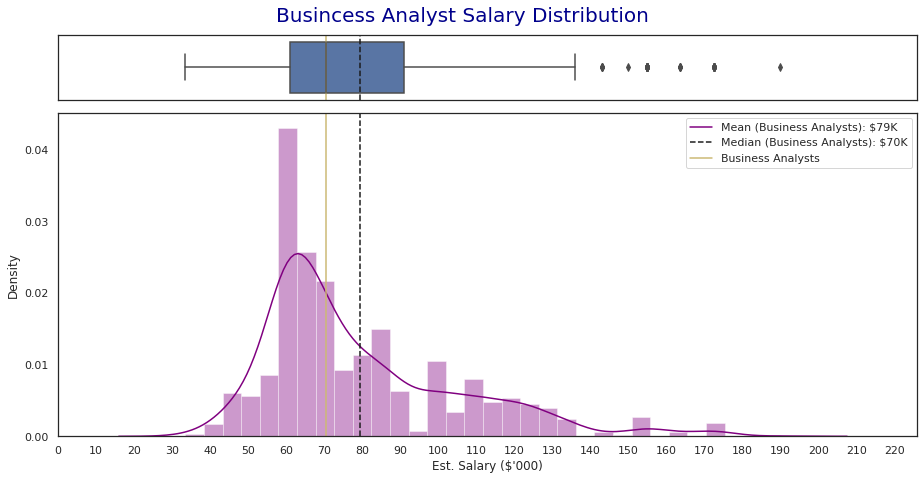

In [39]:
sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=bas.mean()
median=bas.median()

bph = sns.boxplot(bas, ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

bas1 = sns.distplot(bas,ax=ax_hist, color="purple").set(xlabel="Est. Salary ($'000)")

ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (Business Analysts): $'+str(int(mean))+'K':mean,
            'Median (Business Analysts): $'+str(int(median))+'K':median,'Business Analysts':bas})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Busincess Analyst Salary Distribution', fontsize=20,color='darkblue')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


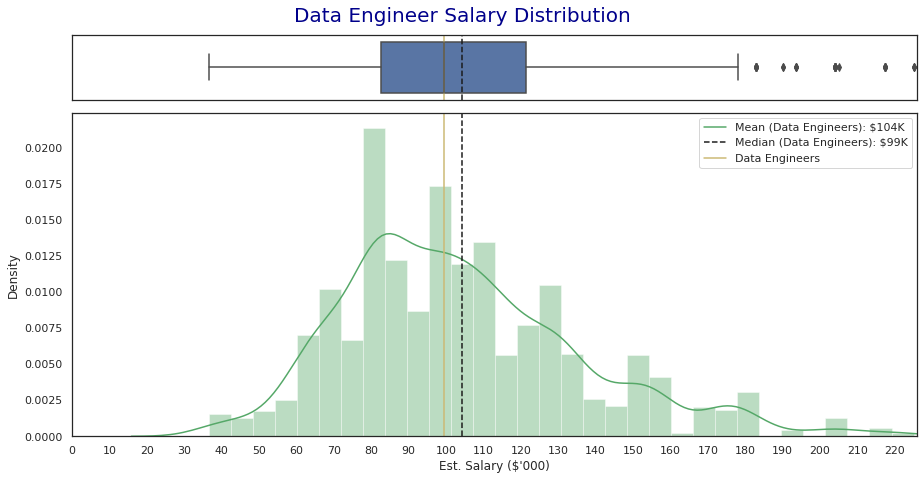

In [40]:
sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=des.mean()
median=des.median()

bph = sns.boxplot(des, ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

des1 = sns.distplot(des,ax=ax_hist, color="g").set(xlabel="Est. Salary ($'000)")

ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (Data Engineers): $'+str(int(mean))+'K':mean,
            'Median (Data Engineers): $'+str(int(median))+'K':median,'Data Engineers':des})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Data Engineer Salary Distribution', fontsize=20,color='darkblue')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


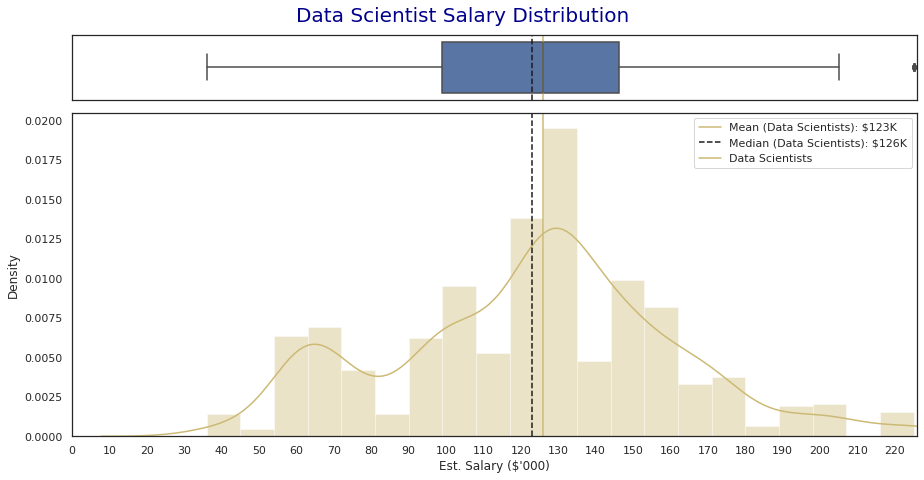

In [41]:
sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=dss.mean()
median=dss.median()

bph = sns.boxplot(dss, ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

des1 = sns.distplot(dss,ax=ax_hist, color="y").set(xlabel="Est. Salary ($'000)")

ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (Data Scientists): $'+str(int(mean))+'K':mean,
            'Median (Data Scientists): $'+str(int(median))+'K':median,'Data Scientists':dss})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Data Scientist Salary Distribution', fontsize=20,color='darkblue')
plt.show()

In [42]:
ds_sal = position_sal[position_sal['Group']=='Data Scientists']
hids_sal = position_sal[(position_sal['Est_Salary']>=90)&(position_sal['Group']=='Data Scientists')]
lowds_sal = position_sal[(position_sal['Est_Salary']<90)&(position_sal['Group']=='Data Scientists')]
da_sal = position_sal[position_sal['Group']=='Data Analysts']
ba_sal = position_sal[position_sal['Group']=='Business Analysts']
de_sal = position_sal[position_sal['Group']=='Data Engineers']

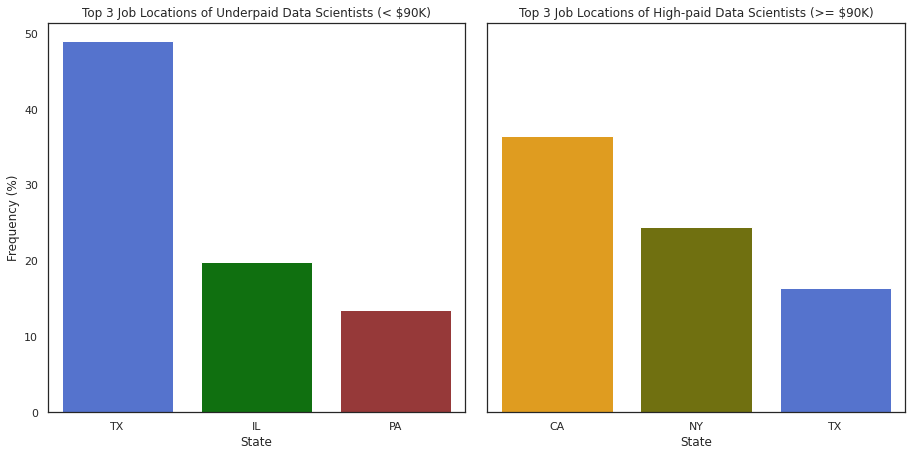

In [43]:
lowds_loc = lowds_sal['State'].value_counts().reset_index().rename(columns={'index':'State','State':'Count'})
lowds_loc['Percentage'] = (lowds_loc['Count']/sum(lowds_loc['Count']))*100
lowds_loc = lowds_loc.iloc[0:3,:]

hids_loc = hids_sal['State'].value_counts().reset_index().rename(columns={'index':'State','State':'Count'})
hids_loc['Percentage'] = (hids_loc['Count']/sum(hids_loc['Count']))*100
hids_loc = hids_loc.iloc[0:3,:]

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

sns.set(style="white")
sns.barplot(x = lowds_loc['State'],y = lowds_loc['Percentage'],ax=axs[0],
            palette=['royalblue','green','brown']).set(
    ylabel='Frequency (%)',title='Top 3 Job Locations of Underpaid Data Scientists (< $90K)')
sns.barplot(x = hids_loc['State'],y = hids_loc['Percentage'],
            palette=['orange','olive','royalblue'],
            ax=axs[1]).set(ylabel='',title='Top 3 Job Locations of High-paid Data Scientists (>= $90K)')

plt.tight_layout(w_pad=0)
plt.show()

### Keywords on Job Titles vs. Salaries
* 'Data Scientist' as job title would have averagely 25K higher salaries holding other variables constant, whereas Analysts' salaries are significantly lower than other data science jobs.
* Points are coefficient of the variables over salary, and lines represent errors (or range estimates).
* 43 out of 51 positions with 'SECTOR' on titles are Data Scientist positions from IBM.
* 'BI' = Business Intelligence.

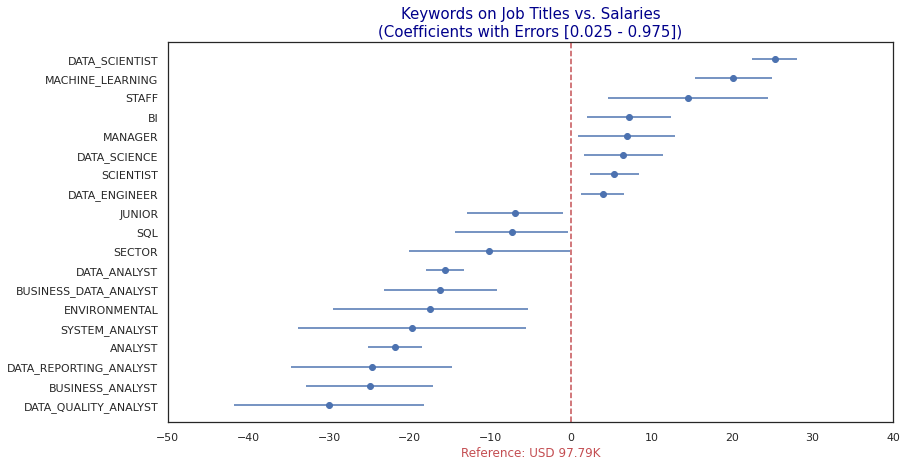

Insignificant Keywords on job titles (removed): ['DATA_WAREHOUSE', 'FEDERAL', 'MARKET', 'HR', 'QUANTUM', 'TECHNICAL', 'ANALYTIC', 'III', 'FINANCIAL', 'MID', 'DIRECTOR', 'AI', 'ENGINEER', 'DATA_MANAGEMENT', 'ENGINEERING', 'QA', 'PROGRAMMER', 'INDUSTRIAL', 'QUALITY', 'PROCESS', 'ENTRY_LEVEL', 'HEALTHCARE', 'DATA_ENGINEERING', 'PROGRAM', 'SENIOR', 'PLANNING', 'D', 'URGENT', 'RESEARCH', 'PRINCIPAL', 'LEVEL', 'SECURITY', 'PRODUCT', 'REPORTING', 'TO', 'ENTERPRISE', 'INSIGHT', 'PLATFORM', 'DATA_GOVERNANCE']


In [44]:
errtable = Coef_title[1:].sort_values('coef',ascending=True)

fig = plt.figure(figsize=(13, 7))
plt.errorbar(y = errtable.index.tolist(), x = errtable['coef'], xerr = errtable['std err']*2, fmt='o')
plt.axvline(x=0, color='r',linestyle='--')
plt.title("Keywords on Job Titles vs. Salaries\n(Coefficients with Errors [0.025 - 0.975])",
          fontsize='15',color='darkblue')
plt.xlabel('Reference: USD 97.79K',color='r')
plt.xticks(np.arange(-50, 50, step=10))
plt.show()

print("Insignificant Keywords on job titles (removed): "+ str(title_remove))

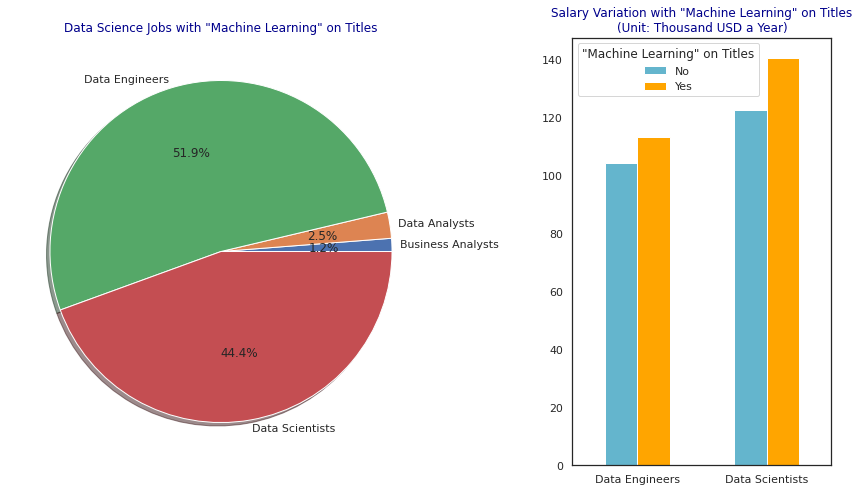

In [45]:
MLs = position_sal.pivot_table(columns='MACHINE_LEARNING',index='Group',values='Est_Salary',aggfunc=[np.mean,'count'])
MLs = MLs.iloc[0:4,:]
MLDADE = MLs.iloc[2:,0:2]

f, axs = plt.subplots(ncols = 2, gridspec_kw= {"width_ratios":(1,0.5)},figsize=(13,7))

axs[0].pie(MLs.iloc[:,3], shadow=True, startangle=0, autopct='%1.1f%%',
           labels=MLs.index.tolist(),labeldistance=1.05)
axs[0].set_title('Data Science Jobs with "Machine Learning" on Titles',color='darkblue')

MLDADE.plot(ax=axs[1],kind='bar',color=['c','orange']).legend(
    title='"Machine Learning" on Titles',labels=['No','Yes'])
axs[1].set_title('Salary Variation with "Machine Learning" on Titles\n(Unit: Thousand USD a Year)',
                color='darkblue')

plt.xlabel('')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Trending Keywords in Job Descriptions: PHD, Master, Python, Machine Learning, SQL and more <a id="JD"></a> 

* Bars are coefficient of the variables over salary, and lines represent errors (or range estimates).
* 'OLTP' appearance in job descriptions has the highest average salary impact but also has the biggest vairance.
* Positions require/prefer PHD degrees obviously are paid more.

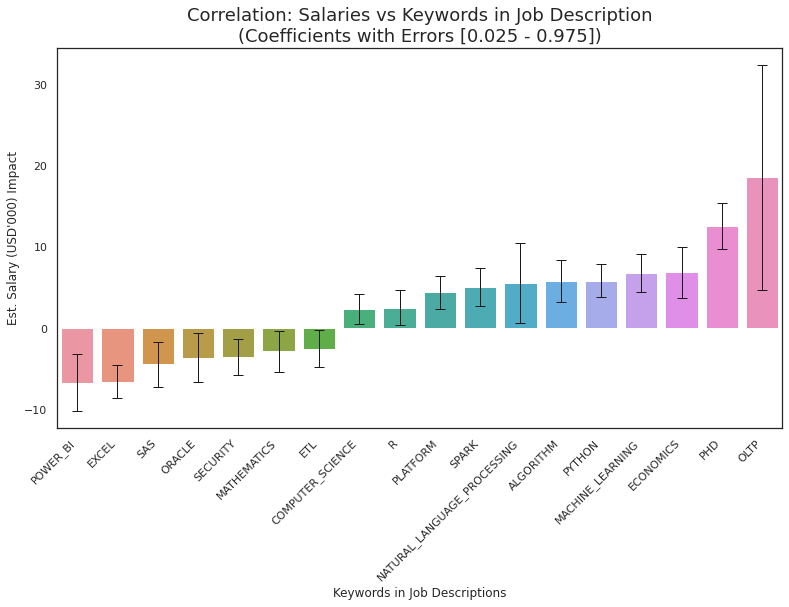

Insignificant Keywords in job descrptions (removed): ['NEURAL_NETWORK_JD', 'API_JD', 'TENSORFLOW_JD', 'NOSQL_JD', 'REDIS_JD', 'HADOOP_JD', 'NETWORK_JD', 'CLUSTER_JD', 'SAP_JD', 'MBA_JD', 'REGRESSION_JD', 'ELASTICSEARCH_JD', 'AWS_JD', 'PMP_JD', 'APACHE_JD', 'CASSANDRA_JD', 'OLAP_JD', 'MYSQL_JD', 'STATISTICS_JD', 'PLSQL_JD', 'DYNAMODB_JD', 'ARTIFICIAL_INTELLIGENCE_JD', 'DEEP_LEARNING_JD']


In [46]:
titlebar = Coef_JD[1:].reset_index().replace('_JD','',regex=True)
titlebar = titlebar.sort_values('coef',ascending=True).reset_index(drop=True)

sns.set(style='white')
fig = plt.figure(figsize=(13, 7))
sns.barplot(x=titlebar['index'], y=titlebar['coef'], yerr=titlebar['std err']*2,error_kw=dict(
    lw=1, capsize=5, capthick=1))
plt.ylabel('Est. Salary (USD\'000) Impact')
plt.xlabel('Keywords in Job Descriptions')
plt.title('Correlation: Salaries vs Keywords in Job Description\n(Coefficients with Errors [0.025 - 0.975])',
          fontsize=18)
plt.xticks(rotation=45,horizontalalignment='right')
plt.show()
print("Insignificant Keywords in job descrptions (removed): "+ str(JD_remove))

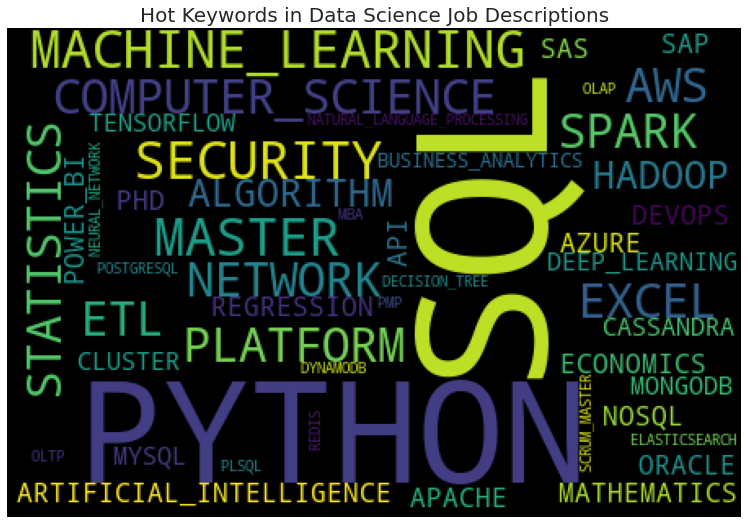

In [47]:
wordCloud = WordCloud(width=450,height= 300).generate(' '.join(S2['KW']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Hot Keywords in Data Science Job Descriptions",fontsize=20)
plt.imshow(wordCloud)
plt.show()

In [48]:
dskw = ds_sal['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
dskw = dskw[dskw['KW'].isin(buzzwords)].reset_index(drop=True)

dakw = da_sal['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
dakw = dakw[dakw['KW'].isin(buzzwords)].reset_index(drop=True)

bakw = ba_sal['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
bakw = bakw[bakw['KW'].isin(buzzwords)].reset_index(drop=True)

dekw = de_sal['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
dekw = dekw[dekw['KW'].isin(buzzwords)].reset_index(drop=True)

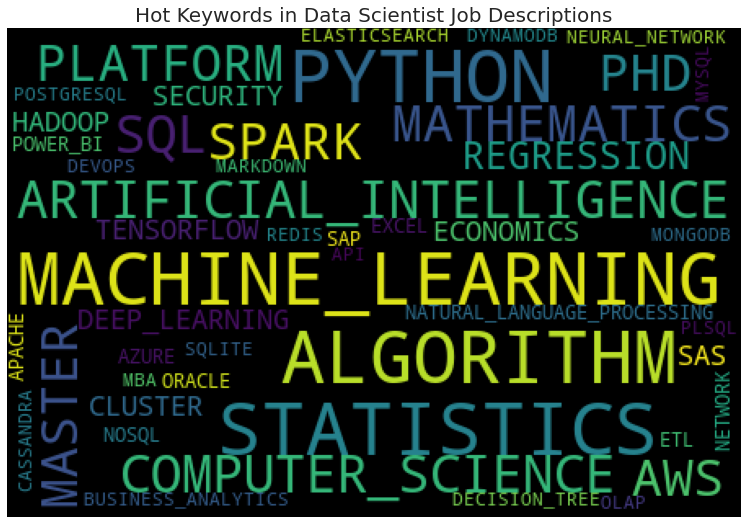

In [49]:
wordCloud = WordCloud(width=450,height= 300).generate(' '.join(dskw['KW']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Hot Keywords in Data Scientist Job Descriptions",fontsize=20)
plt.imshow(wordCloud)
plt.show()

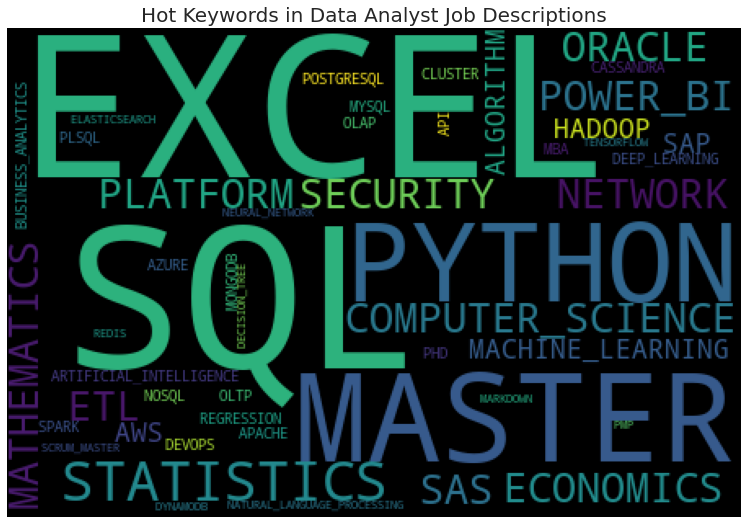

In [50]:
wordCloud = WordCloud(width=450,height= 300).generate(' '.join(dakw['KW']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Hot Keywords in Data Analyst Job Descriptions",fontsize=20)
plt.imshow(wordCloud)
plt.show()

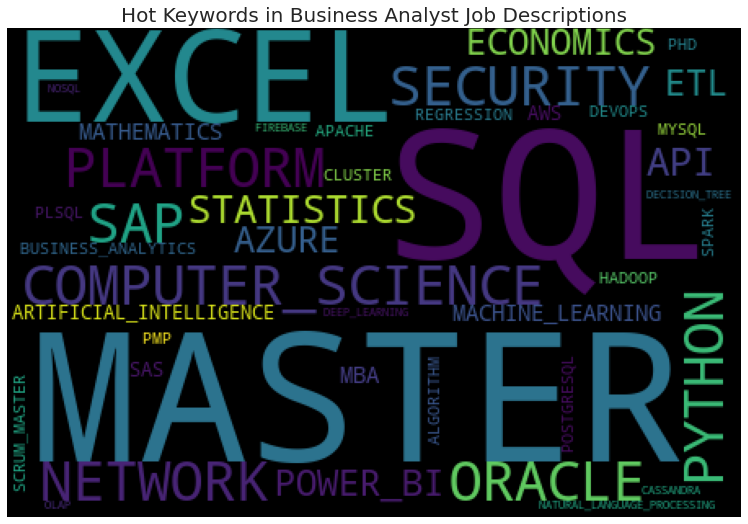

In [51]:
wordCloud = WordCloud(width=450,height= 300).generate(' '.join(bakw['KW']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Hot Keywords in Business Analyst Job Descriptions",fontsize=20)
plt.imshow(wordCloud)
plt.show()

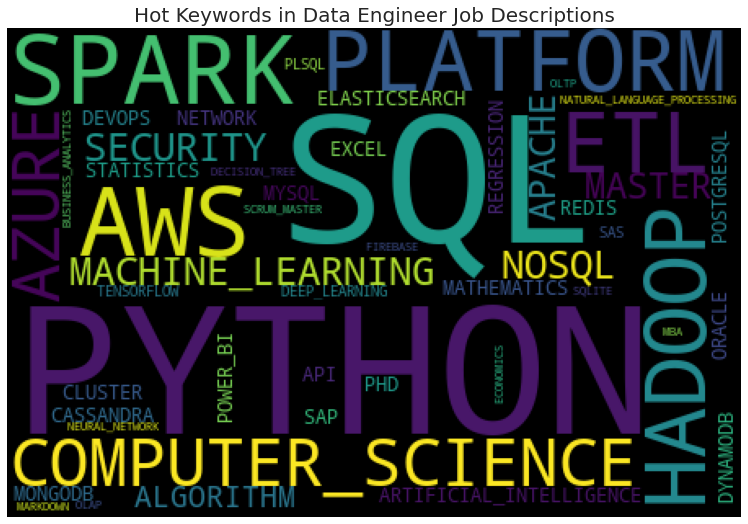

In [52]:
wordCloud = WordCloud(width=450,height= 300).generate(' '.join(dekw['KW']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Hot Keywords in Data Engineer Job Descriptions",fontsize=20)
plt.imshow(wordCloud)
plt.show()

## Salary Comparison: California Cities at the top 

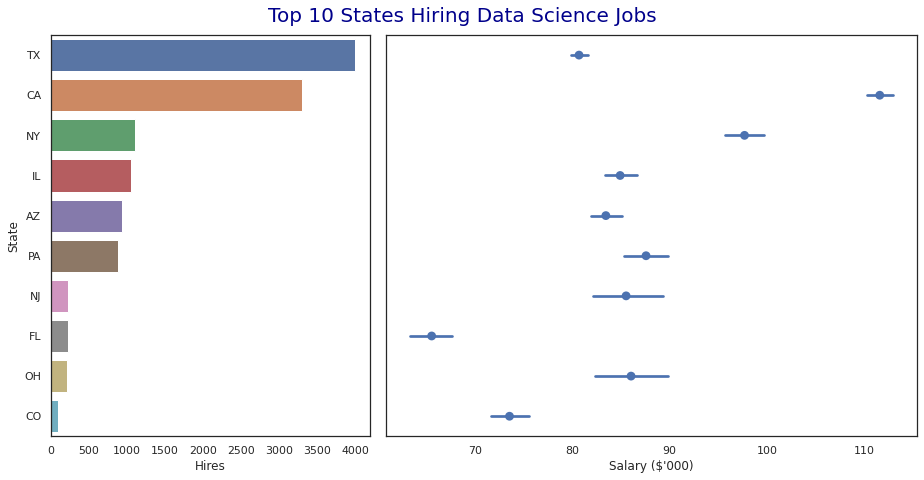

In [53]:
stateCount = data.groupby('State')[['Job Title']].count().reset_index().rename(columns={'Job Title':'Hires'}).sort_values(
    'Hires', ascending=False).reset_index(drop=True).head(10)
stateCount = stateCount.merge(data, on='State',how='left')

sns.set(style="white")
f, (ax_bar, ax_point) = plt.subplots(ncols=2, sharey=True, gridspec_kw= {"width_ratios":(0.6,1)},figsize=(13,7))
sns.barplot(x='Hires',y='State',data=stateCount,ax=ax_bar)
sns.pointplot(x='Est_Salary',y='State',data=stateCount, join=False,ax=ax_point).set(ylabel="",xlabel="Salary ($'000)")
plt.suptitle('Top 10 States Hiring Data Science Jobs',fontsize=20,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

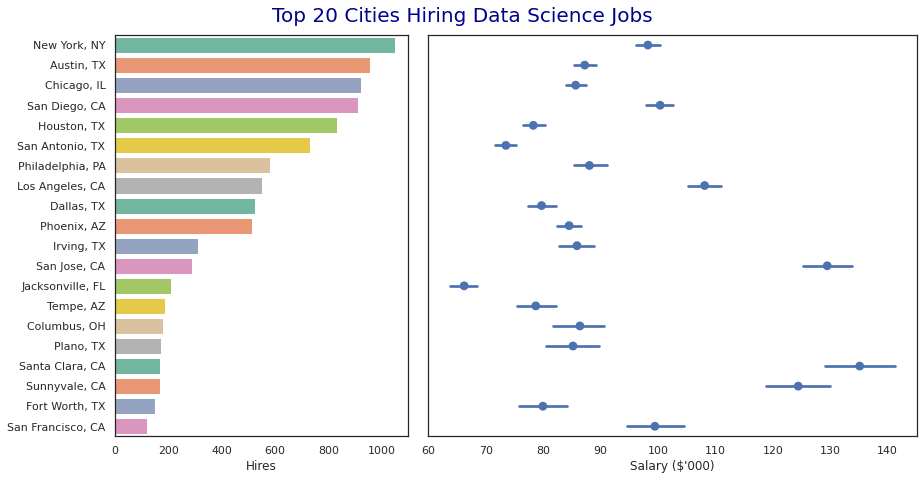

In [54]:
df_by_city=data.groupby('Location')['Job Title'].count().reset_index().sort_values(
    'Job Title',ascending=False).head(20).rename(columns={'Job Title':'Hires'})
Sal_by_city = df_by_city.merge(data,on='Location',how='left')

sns.set(style="white")
f, (ax_bar, ax_point) = plt.subplots(ncols=2, sharey=True, gridspec_kw= {"width_ratios":(0.6,1)},figsize=(13,7))
sns.barplot(x='Hires',y='Location',data=Sal_by_city,ax=ax_bar, palette='Set2').set(ylabel="")
sns.pointplot(x='Est_Salary',y='Location',data=Sal_by_city, join=False,ax=ax_point).set(
    ylabel="",xlabel="Salary ($'000)")
plt.suptitle('Top 20 Cities Hiring Data Science Jobs',fontsize=20,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Higher Company Rating is associated with slightly higher salaries 

Positive correlation is obvious from rating 2.5 and higher...


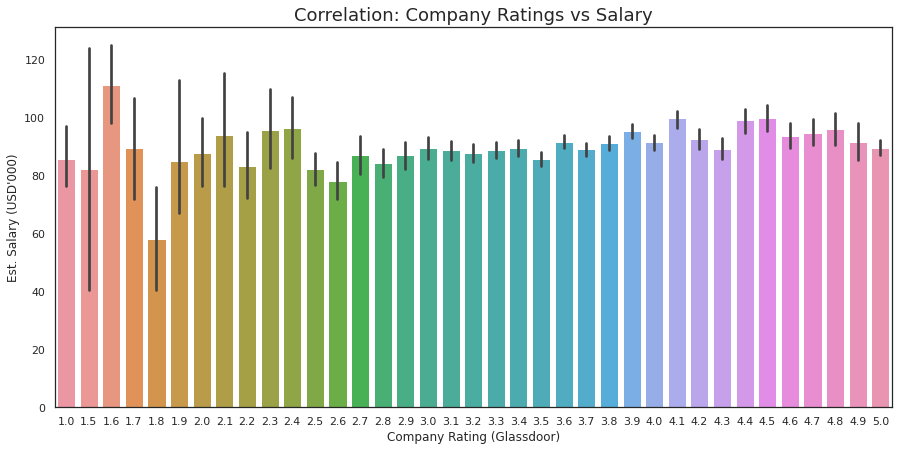

In [55]:
fig = plt.figure(figsize=(15, 7))
sns.barplot(x='Rating', y='Est_Salary', data=data)
plt.ylabel('Est. Salary (USD\'000)')
plt.xlabel('Company Rating (Glassdoor)')
plt.title('Correlation: Company Ratings vs Salary',fontsize=18)
print('Positive correlation is obvious from rating 2.5 and higher...')
plt.show()

## Heatmaps : Company Size, Scale and Salaries 

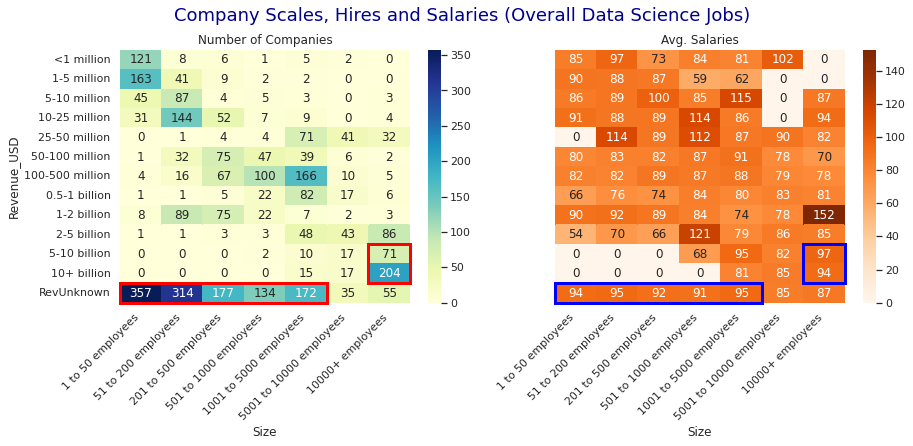

In [56]:
Firm_Size = position_sal.pivot_table(columns="Size",index="Revenue_USD",values="Company Name",aggfunc=pd.Series.nunique).reset_index()
Firm_Size = Firm_Size.drop([0])
Firm_Size = Firm_Size[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size = Firm_Size.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size = Firm_Size.set_index('Revenue_USD').replace(np.nan,0)

Firm_Size_Sal = position_sal.pivot_table(columns="Size",index="Revenue_USD",values="Est_Salary",aggfunc=np.mean).reset_index()
Firm_Size_Sal = Firm_Size_Sal.drop([0])
Firm_Size_Sal = Firm_Size_Sal[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size_Sal = Firm_Size_Sal.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size_Sal = Firm_Size_Sal.set_index('Revenue_USD').replace(np.nan,0)

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

fs = sns.heatmap(Firm_Size,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="YlGnBu", ax=axs[0]).set(title="Number of Companies")
fss = sns.heatmap(Firm_Size_Sal,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="Oranges",ax=axs[1]).set(title="Avg. Salaries",ylabel='')

axs[0].add_patch(Rectangle((6,10), 1, 2, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[0].add_patch(Rectangle((0,12), 5, 1, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((6,10), 1, 2, fill=False, edgecolor='blue', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((0,12), 5, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

plt.setp([a.get_xticklabels() for a in axs[:]],rotation=45,ha='right')
plt.suptitle('Company Scales, Hires and Salaries (Overall Data Science Jobs)',fontsize=18,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

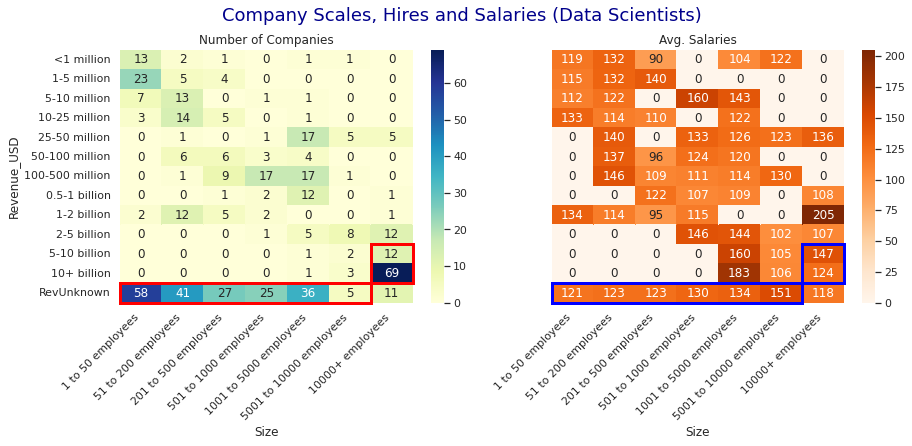

In [57]:
Firm_Size = ds_sal.pivot_table(columns="Size",index="Revenue_USD",values="Company Name",aggfunc=pd.Series.nunique).reset_index()
Firm_Size = Firm_Size.drop([0])
Firm_Size = Firm_Size[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size = Firm_Size.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size = Firm_Size.set_index('Revenue_USD').replace(np.nan,0)

Firm_Size_Sal = ds_sal.pivot_table(columns="Size",index="Revenue_USD",values="Est_Salary",aggfunc=np.mean).reset_index()
Firm_Size_Sal = Firm_Size_Sal.drop([0])
Firm_Size_Sal = Firm_Size_Sal[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size_Sal = Firm_Size_Sal.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size_Sal = Firm_Size_Sal.set_index('Revenue_USD').replace(np.nan,0)

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

fs = sns.heatmap(Firm_Size,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="YlGnBu", ax=axs[0]).set(title="Number of Companies")
fss = sns.heatmap(Firm_Size_Sal,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="Oranges",ax=axs[1]).set(title="Avg. Salaries",ylabel='')

axs[0].add_patch(Rectangle((6,10), 1, 2, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[0].add_patch(Rectangle((0,12), 6, 1, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((6,10), 1, 2, fill=False, edgecolor='blue', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((0,12), 6, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

plt.setp([a.get_xticklabels() for a in axs[:]],rotation=45,ha='right')
plt.suptitle('Company Scales, Hires and Salaries (Data Scientists)',fontsize=18,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

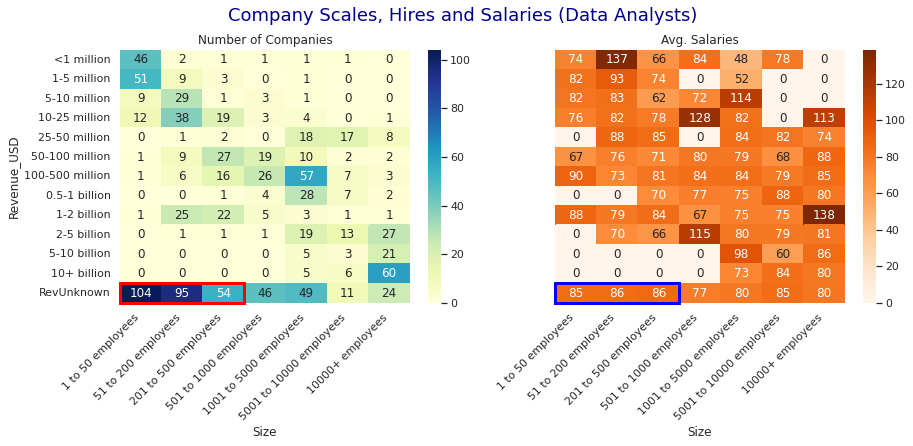

In [58]:
Firm_Size = da_sal.pivot_table(columns="Size",index="Revenue_USD",values="Company Name",aggfunc=pd.Series.nunique).reset_index()
Firm_Size = Firm_Size.drop([0])
Firm_Size = Firm_Size[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size = Firm_Size.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size = Firm_Size.set_index('Revenue_USD').replace(np.nan,0)

Firm_Size_Sal = da_sal.pivot_table(columns="Size",index="Revenue_USD",values="Est_Salary",aggfunc=np.mean).reset_index()
Firm_Size_Sal = Firm_Size_Sal.drop([0])
Firm_Size_Sal = Firm_Size_Sal[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size_Sal = Firm_Size_Sal.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size_Sal = Firm_Size_Sal.set_index('Revenue_USD').replace(np.nan,0)

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

fs = sns.heatmap(Firm_Size,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="YlGnBu", ax=axs[0]).set(title="Number of Companies")
fss = sns.heatmap(Firm_Size_Sal,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="Oranges",ax=axs[1]).set(title="Avg. Salaries",ylabel='')

axs[0].add_patch(Rectangle((0,12), 3, 1, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((0,12), 3, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

plt.setp([a.get_xticklabels() for a in axs[:]],rotation=45,ha='right')
plt.suptitle('Company Scales, Hires and Salaries (Data Analysts)',fontsize=18,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

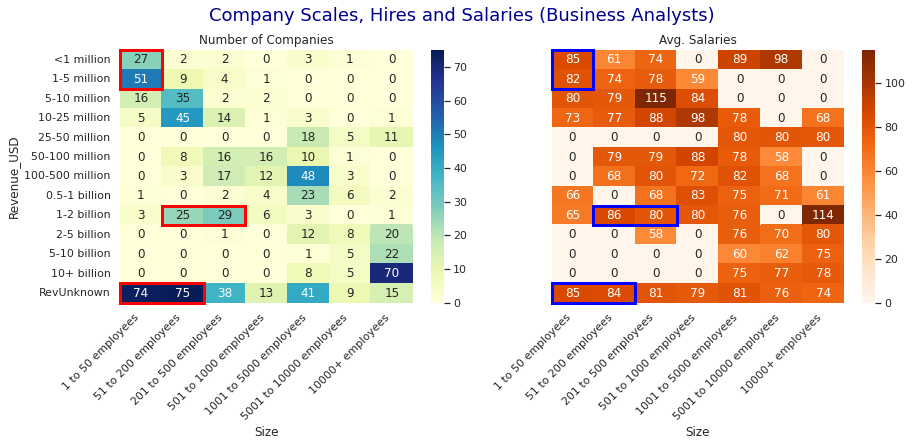

In [59]:
Firm_Size = ba_sal.pivot_table(columns="Size",index="Revenue_USD",values="Company Name",aggfunc=pd.Series.nunique).reset_index()
Firm_Size = Firm_Size.drop([0])
Firm_Size = Firm_Size[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size = Firm_Size.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size = Firm_Size.set_index('Revenue_USD').replace(np.nan,0)

Firm_Size_Sal = ba_sal.pivot_table(columns="Size",index="Revenue_USD",values="Est_Salary",aggfunc=np.mean).reset_index()
Firm_Size_Sal = Firm_Size_Sal.drop([0])
Firm_Size_Sal = Firm_Size_Sal[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size_Sal = Firm_Size_Sal.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size_Sal = Firm_Size_Sal.set_index('Revenue_USD').replace(np.nan,0)

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

fs = sns.heatmap(Firm_Size,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="YlGnBu", ax=axs[0]).set(title="Number of Companies")
fss = sns.heatmap(Firm_Size_Sal,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="Oranges",ax=axs[1]).set(title="Avg. Salaries",ylabel='')

axs[0].add_patch(Rectangle((0,0), 1, 2, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[0].add_patch(Rectangle((1,8), 2, 1, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[0].add_patch(Rectangle((0,12), 2, 1, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((0,0), 1, 2, fill=False, edgecolor='blue', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((1,8), 2, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((0,12), 2, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

plt.setp([a.get_xticklabels() for a in axs[:]],rotation=45,ha='right')
plt.suptitle('Company Scales, Hires and Salaries (Business Analysts)',fontsize=18,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

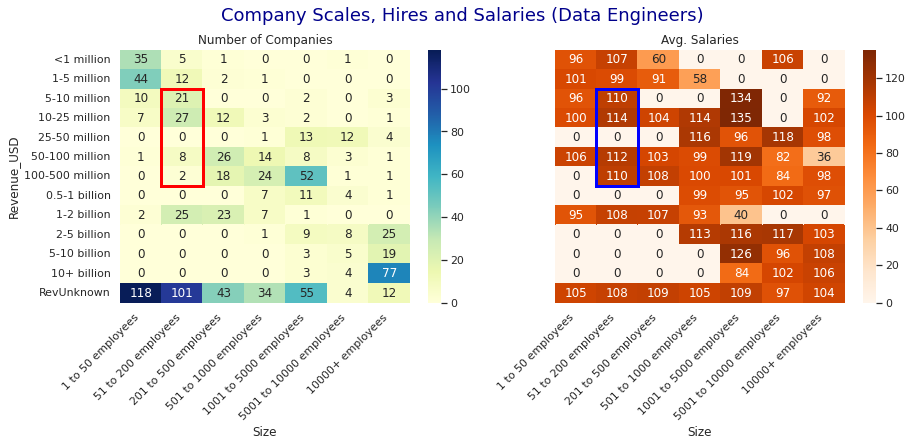

In [60]:
Firm_Size = de_sal.pivot_table(columns="Size",index="Revenue_USD",values="Company Name",aggfunc=pd.Series.nunique).reset_index()
Firm_Size = Firm_Size.drop([0])
Firm_Size = Firm_Size[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size = Firm_Size.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size = Firm_Size.set_index('Revenue_USD').replace(np.nan,0)

Firm_Size_Sal = de_sal.pivot_table(columns="Size",index="Revenue_USD",values="Est_Salary",aggfunc=np.mean).reset_index()
Firm_Size_Sal = Firm_Size_Sal.drop([0])
Firm_Size_Sal = Firm_Size_Sal[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size_Sal = Firm_Size_Sal.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size_Sal = Firm_Size_Sal.set_index('Revenue_USD').replace(np.nan,0)

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

fs = sns.heatmap(Firm_Size,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="YlGnBu", ax=axs[0]).set(title="Number of Companies")
fss = sns.heatmap(Firm_Size_Sal,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="Oranges",ax=axs[1]).set(title="Avg. Salaries",ylabel='')

axs[0].add_patch(Rectangle((1,2), 1, 5, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((1,2), 1, 5, fill=False, edgecolor='blue', lw=3, clip_on=False))

plt.setp([a.get_xticklabels() for a in axs[:]],rotation=45,ha='right')
plt.suptitle('Company Scales, Hires and Salaries (Data Engineers)',fontsize=18,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## First Combined Regression Model Output 

In [61]:
Mod_Final

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Est_Salary   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     98.59
Date:                Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:38:22   Log-Likelihood:                -35268.
No. Observations:                7371   AIC:                         7.062e+04
Df Residuals:                    7328   BIC:                         7.092e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Const                     92.7810      1.059     87.635      0.000      90.706      94.856
Rating                     0.6170      0.259      2.382      0.017       0.109       1.125
Easy_Apply                 5.3752      1.666      3.227      0.001       2.110       8.640
DATA_SCIENCE               4.8639      2.100      2.316      0.021       0.747       8.981
SYSTEM_ANALYST           -27.7935      6.235     -4.458      0.000     -40.016     -15.571
BI                         7.4939      2.316      3.235      0.001       2.953      12.035
DATA_QUALITY_ANALYST     -32.9137      5.185     -6.348      0.000     -43.078     -22.749
MACHINE_LEARNING           7.1900      2.146      3.350      0.001       2.982      11.397
DATA_REPORTING_ANALYST   -26.7256      4.384     -6.096      0.000     -35.320     -18.131
DATA_SCIENTIST            14.1279      1.128     12.528      0.000      11.917      16.339
DATA_ANALYST             -20.3388      0.828    -24.555      0.000     -21.962     -18.715
ANALYST                  -23.8201      1.373    -17.353      0.000     -26.511     -21.129
BUSINESS_ANALYST         -26.5683      3.479     -7.637      0.000     -33.388     -19.748
STAFF                      9.5622      4.425      2.161      0.031       0.887      18.237
BUSINESS_DATA_ANALYST    -22.2514      3.056     -7.281      0.000     -28.242     -16.261
OLTP_JD                   13.4316      5.832      2.303      0.021       1.998      24.865
PHD_JD                     2.7884      1.192      2.340      0.019       0.452       5.125
ECONOMICS_JD               3.0387      1.277      2.380      0.017       0.536       5.541
CA                        20.5128      1.250     16.404      0.000      18.062      22.964
FL                       -14.3771      3.015     -4.769      0.000     -20.287      -8.467
WA                        -9.1133      4.054     -2.248      0.025     -17.061      -1.166
VA                        -9.7261      4.240     -2.294      0.022     -18.038      -1.414
UT                       -36.9265      5.180     -7.129      0.000     -47.081     -26.772
Newark                    17.9908      5.959      3.019      0.003       6.309      29.673
Dallas                   -12.7945      1.921     -6.659      0.000     -16.561      -9.028
Mountain_View             27.9374      4.125      6.772      0.000      19.851      36.024
San_Jose                  34.0083      2.704     12.578      0.000      28.708      39.309
New_York                  11.9150      1.152     10.347      0.000       9.658      14.172
San_Diego                 -7.4881      1.934     -3.872      0.000     -11.279      -3.697
Plano                     -6.8478      3.138     -2.182      0.029     -12.999      -0.697
Menlo_Park                26.1646      5.000      5.233      0.000      16.364  

# Model Tuning 

In [62]:
modelperform = pd.DataFrame(
        columns = [
            'Model','Adj. R-squared','AIC','BIC','R2','RMSE','R2_val','RMSE_val','R2_test','RMSE_test'])

modelperform, X_train1, X_val1, X_test1 = scalibility('Combined Model',Mod_Final_1, Mod_Final_2)
modelperform

,Model,Adj. R-squared,AIC,BIC,R2,RMSE,R2_val,RMSE_val,R2_test,RMSE_test
0,Combined Model,0.3570,70620.0000,70920.0000,0.3610,28.9573,0.2356,28.4777,0.0806,25.4430


## Tune the first combined model with Elastic Net 

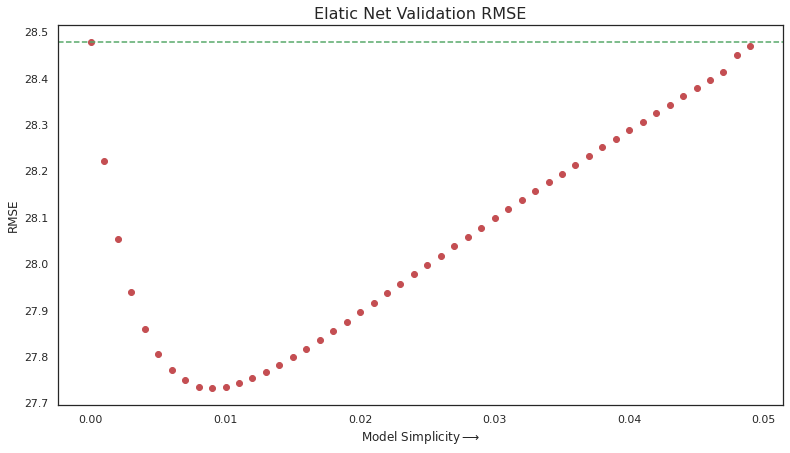

In [63]:
ElasticNetPlot(alpha_max = 0.05, alpha_step = 0.001, L1_wt_value = 0.5)

Elastic Net Regression suggests that the validation error of this model is close to optimal but could be lower if alpha increases to 0.008, implying some variable removal may make the model better.

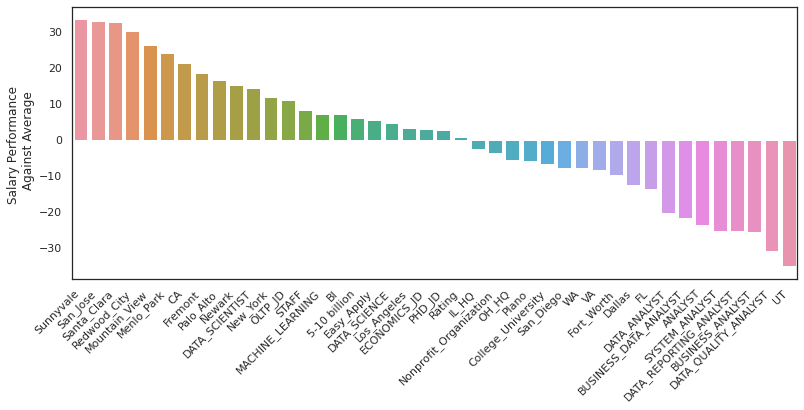

In [64]:
coefficientbars(alpha_value = 0.008, L1_wt_value = 1, Mod_Final_2 = Mod_Final_2)

However, even with Lasso at alpha=0.008, no variables is necessariliy to be removed. Nevertheless, let's introduce some relevant interaction terms to see if it can get us more explainability.

## Introduce interaction terms to the first combined model 

In [65]:
X_train, X_val, X_test, Interactions_Top = addTopInteractions()

Streaming output truncated to the last 5000 lines.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/pyt

In [66]:
# Add interaction terms to regression's variable list
model_var_intr = Interactions_Top[Interactions_Top['inter'].isin(X_train.columns)]['inter']
FinalVar_intr = list(Mod_Final_2['index']) + list(model_var_intr)
FinalVar_intr2 = list(Mod_Final_2[Mod_Final_2['index']!='Const']['index']) + list(model_var_intr)
FinalVar_intr_table = pd.DataFrame(FinalVar_intr,columns=['Var'])

## Final Model (Tuned)

In [67]:
intr_remove = []

X_opt_Final_t, Final_name_t = backwardeliminate(FinalVar_intr, intr_remove, FinalVar_intr_table, FinalVar_intr2)
Mod_Final_t, VIF_Final_t, mod_Final_t = buildmodel(X_opt_Final_t, Final_name_t)
Coef_Final_t = resulttable(Mod_Final_t)

i = max(Coef_Final_t[Coef_Final_t.index.isin(model_var_intr)]['P>|t|'])
while i > regr_p:
    intr_remove.append(Coef_Final_t.index[Coef_Final_t['P>|t|']==i].values[0])
    X_opt_Final_t, Final_name_t = backwardeliminate(
        FinalVar_intr, intr_remove, FinalVar_intr_table, FinalVar_intr2)
    Mod_Final_t, VIF_Final_t, mod_Final_t = buildmodel(X_opt_Final_t, Final_name_t)
    Coef_Final_t = resulttable(Mod_Final_t)
    i = max(Coef_Final_t[Coef_Final_t.index.isin(model_var_intr)]['P>|t|'])

Mod_Final_1_t,Mod_Final_2_t,Mod_Final_3_t = resulttables(Mod_Final_t, VIF_Final_t)
Mod_Final_t


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Est_Salary   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     90.31
Date:                Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                -35234.
No. Observations:                7371   AIC:                         7.056e+04
Df Residuals:                    7323   BIC:                         7.090e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Const                     94.6120      1.182     80.028      0.000      92.295      96.930
Rating                     0.1489      0.300      0.496      0.620      -0.440       0.738
Easy_Apply                 5.3021      1.659      3.196      0.001       2.050       8.554
DATA_SCIENCE               5.0172      2.092      2.398      0.016       0.916       9.118
SYSTEM_ANALYST           -25.8613      6.216     -4.161      0.000     -38.046     -13.677
BI                        -2.6986      3.122     -0.864      0.387      -8.819       3.422
DATA_QUALITY_ANALYST     -33.2032      5.164     -6.430      0.000     -43.325     -23.081
MACHINE_LEARNING           6.7978      2.139      3.177      0.001       2.604      10.992
DATA_REPORTING_ANALYST   -26.8973      4.366     -6.160      0.000     -35.457     -18.338
DATA_SCIENTIST            15.4012      1.157     13.309      0.000      13.133      17.670
DATA_ANALYST             -20.6455      0.840    -24.576      0.000     -22.292     -18.999
ANALYST                  -25.7824      1.430    -18.029      0.000     -28.586     -22.979
BUSINESS_ANALYST         -26.1802      3.466     -7.553      0.000     -32.975     -19.385
STAFF                      9.4485      4.407      2.144      0.032       0.810      18.087
BUSINESS_DATA_ANALYST    -22.6508      3.047     -7.435      0.000     -28.623     -16.679
OLTP_JD                   13.2206      5.813      2.274      0.023       1.826      24.615
PHD_JD                     0.1830      1.470      0.125      0.901      -2.698       3.064
ECONOMICS_JD               2.9646      1.272      2.330      0.020       0.471       5.458
CA                        15.0636      2.307      6.529      0.000      10.541      19.586
FL                       -14.7197      3.003     -4.901      0.000     -20.607      -8.833
WA                        -8.4857      4.040     -2.100      0.036     -16.405      -0.566
VA                        -8.9813      4.227     -2.125      0.034     -17.267      -0.695
UT                       -36.8146      5.159     -7.136      0.000     -46.928     -26.701
Newark                    17.3391      5.936      2.921      0.003       5.704      28.975
Dallas                   -12.8906      1.913     -6.738      0.000     -16.641      -9.140
Mountain_View             26.3606      4.123      6.394      0.000      18.279      34.442
San_Jose                  33.3970      2.695     12.393      0.000      28.114      38.680
New_York                  11.9497      1.149     10.404      0.000       9.698      14.201
San_Diego                -10.2327      2.137     -4.788      0.000     -14.423      -6.043
Plano                     -7.1709      3.125     -2.294      0.022     -13.297      -1.044
Menlo_Park                25.0490      4.985      5.025      0.000      15.278  

In [68]:
modelperform, X_train1, X_val1, X_test1 = scalibility('Final Model (Tuned)',Mod_Final_1_t,Mod_Final_2_t)
modelperform

,Model,Adj. R-squared,AIC,BIC,R2,RMSE,R2_val,RMSE_val,R2_test,RMSE_test
0,Combined Model,0.3570,70620.0000,70920.0000,0.3610,28.9573,0.2356,28.4777,0.0806,25.4430
1,Final Model (Tuned),0.3630,70560.0000,70900.0000,0.3669,28.8235,0.2306,28.5694,0.0787,25.4693


### Thus we achieve an accuracy of **94.64%** of the final tuned model. 

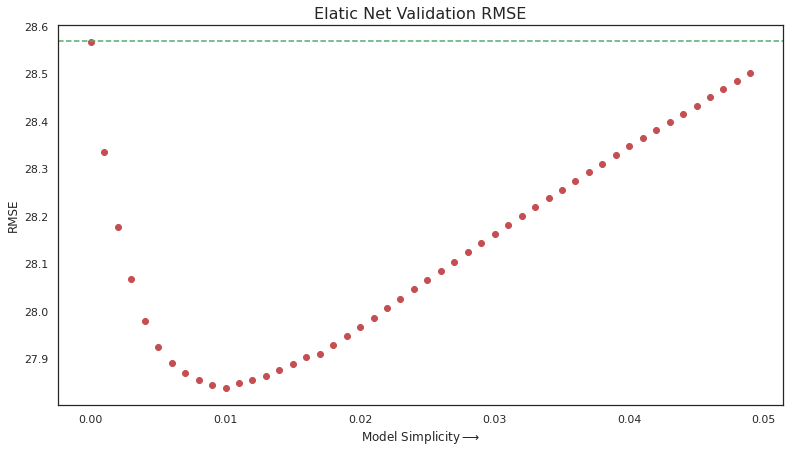

In [69]:
ElasticNetPlot(alpha_max = 0.05, alpha_step = 0.001, L1_wt_value = 0.5)

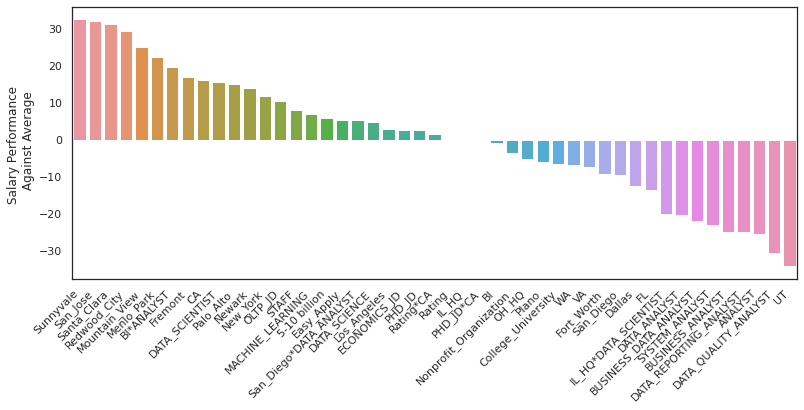

In [70]:
coefficientbars(alpha_value = 0.01, L1_wt_value = 1, Mod_Final_2 = Mod_Final_2_t)

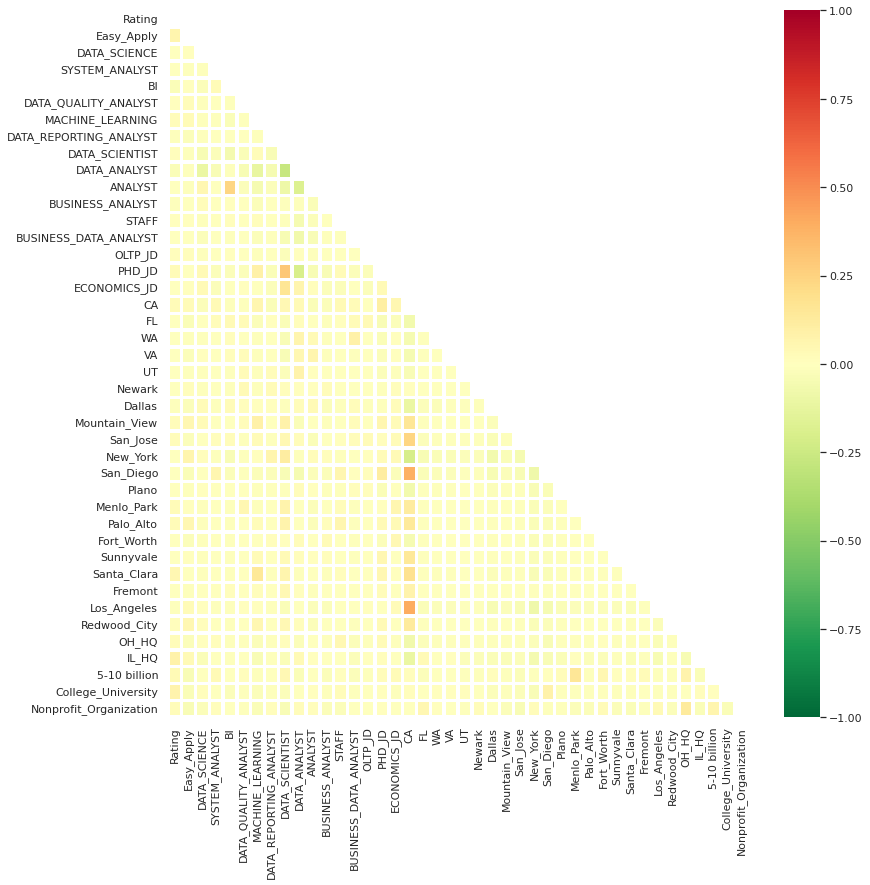

In [71]:
multicol(Coef_Final)

In [72]:
# label for final regression visualisation
Mod_Final_2['Label'] = ['Const',
 'Company Rating (Glassdoor)',
 'Has "Easy Apply"',
 '"Data Science" on Title',
 'SYSTEM_ANALYST',
 '"Business Intelligence" on Title',
 'DATA_QUALITY_ANALYST',
 '"MACHINE_LEARNING" on Title',
 'DATA_REPORTING_ANALYST',
 'DATA_SCIENTIST',
 'DATA_ANALYST',
 'Other Analysts',
 'BUSINESS_ANALYST',
 '"STAFF" on Title',
 'BUSINESS_DATA_ANALYST',
 '"OLTP" in JD',
 '"PHD" in JD',
 '"ECONOMICS" in JD',
 'Job Location: CA',
 'Job Location: FL',
 'Job Location: WA',
 'Job Location: VA',                        
 'Job Location: UT',
 'Job Location: Newark',
 'Job Location: Dallas',                        
 'Job Location: Mountain_View',                       
 'Job Location: San_Jose',
 'Job Location: New_York',
 'Job Location: San_Diego',
 'Job Location: Plano',
 'Job Location: Menlo_Park',
 'Job Location: Palo_Alto',
 'Job Location: Fort_Worth',
 'Job Location: Sunnyvale',
 'Job Location: Santa_Clara',
 'Job Location: Fremont',
 'Job Location: Los Angeles',
 'Job Location: Redwood_City',
 'OH-based firm',
 'IL-based firm',
 'Revenue USD5-10B',
 'College/University',
 'Nonprofit_Organization']


## Data Science Job Salary Impact Map (Final Regression Result) 

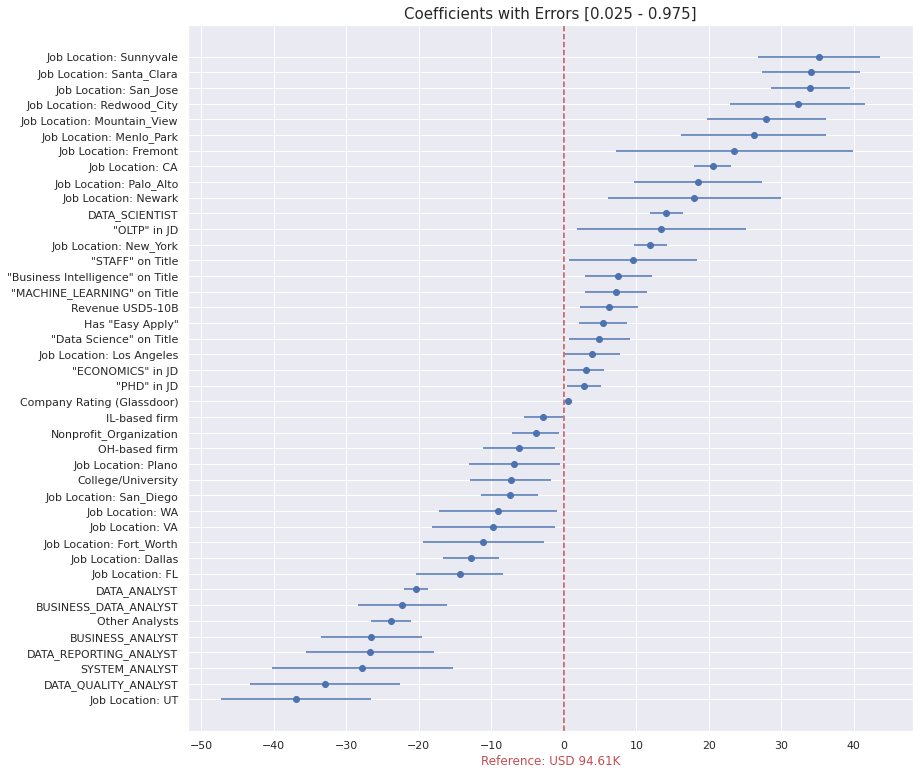

In [73]:
plt_coef = Mod_Final_2[Mod_Final_2['Label']!='Const'].sort_values(
    ['coef','std err'],ascending=True).reset_index(drop=True)

sns.set()
fig = plt.figure(figsize=(13, 13))
plt.errorbar(y = plt_coef.iloc[:,8], x = plt_coef.iloc[:,1], 
             xerr = plt_coef.iloc[:,2]*2, fmt='o', color='b')
plt.axvline(x=0, color='r',linestyle='--')
plt.title("Coefficients with Errors [0.025 - 0.975]",fontsize='15')
plt.xlabel('Reference: USD 94.61K', color='r')
plt.xticks(np.arange(-50, 50, step=10))
plt.show()